<a href="https://colab.research.google.com/github/Fraanas/CustomerSegmentationOlist/blob/main/CustomerSegmentationOlist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data import and loading


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import glob
import os
import datetime as dt
from datetime import datetime, timedelta
import time
import gdown

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.io as pio
from plotly.offline import iplot


#import geoplot as gplt
#import geopandas as gpd
#import geoplot.crs as gcrs

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
df_olist_customers                    = pd.read_csv('brazil_ecom_Dataset/olist_customers_dataset.csv')
df_olist_sellers                      = pd.read_csv('brazil_ecom_Dataset/olist_geolocation_dataset.csv')
df_olist_order_reviews                = pd.read_csv('brazil_ecom_Dataset/olist_order_reviews_dataset.csv')
df_olist_order_items                  = pd.read_csv('brazil_ecom_Dataset/olist_order_items_dataset.csv')
df_olist_products                     = pd.read_csv('brazil_ecom_Dataset/olist_products_dataset.csv')
df_olist_geolocation                  = pd.read_csv('brazil_ecom_Dataset/olist_geolocation_dataset.csv')
df_product_category_name_translation  = pd.read_csv('brazil_ecom_Dataset/product_category_name_translation.csv')
df_olist_orders                       = pd.read_csv('brazil_ecom_Dataset/olist_orders_dataset.csv')
df_olist_order_payments               = pd.read_csv('brazil_ecom_Dataset/olist_order_payments_dataset.csv')

In [7]:
dataframe_names = [
    'df_olist_customers',
    'df_olist_sellers',
    'df_olist_order_reviews',
    'df_olist_order_items',
    'df_olist_products',
    'df_olist_geolocation',
    'df_product_category_name_translation',
    'df_olist_orders',
    'df_olist_order_payments']

#funkcja do sprawdzania liczby wierszy i kolumn w danym datasetcie
def get_data_info(df_name):
  data_info = {}
  for dataset_name in df_name:
      dataset = globals()[dataset_name]
      if dataset is not None and isinstance(dataset, pd.DataFrame):
        num_rows, num_cols = dataset.shape
        data_info[dataset_name] = {'Number of rows': num_rows, 'Number of columns': num_cols}
      else:
        print(f"Warning: '{dataset_name}' is either not defined or not a DataFrame.")
  return pd.DataFrame(data_info).T

df_info = get_data_info(dataframe_names)
df_info

Number of rows  Number of columns
df_olist_customers                             99441                  5
df_olist_sellers                             1000163                  5
df_olist_order_reviews                         99224                  7
df_olist_order_items                          112650                  7
df_olist_products                              32951                  9
df_olist_geolocation                         1000163                  5
df_product_category_name_translation              71                  2
df_olist_orders                                99441                  8
df_olist_order_payments                       103886                  5

In [8]:
df_olist_geolocation.head()

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   
2                         1046       -23.546129       -46.642951   
3                         1041       -23.544392       -46.639499   
4                         1035       -23.541578       -46.641607   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
2        sao paulo                SP  
3        sao paulo                SP  
4        sao paulo                SP

In [9]:
quantity_of_orders = df_olist_orders['order_id'].nunique()
print(f'Zostało złożonych {quantity_of_orders} unikatowych zamówień')

Zostało złożonych 99441 unikatowych zamówień


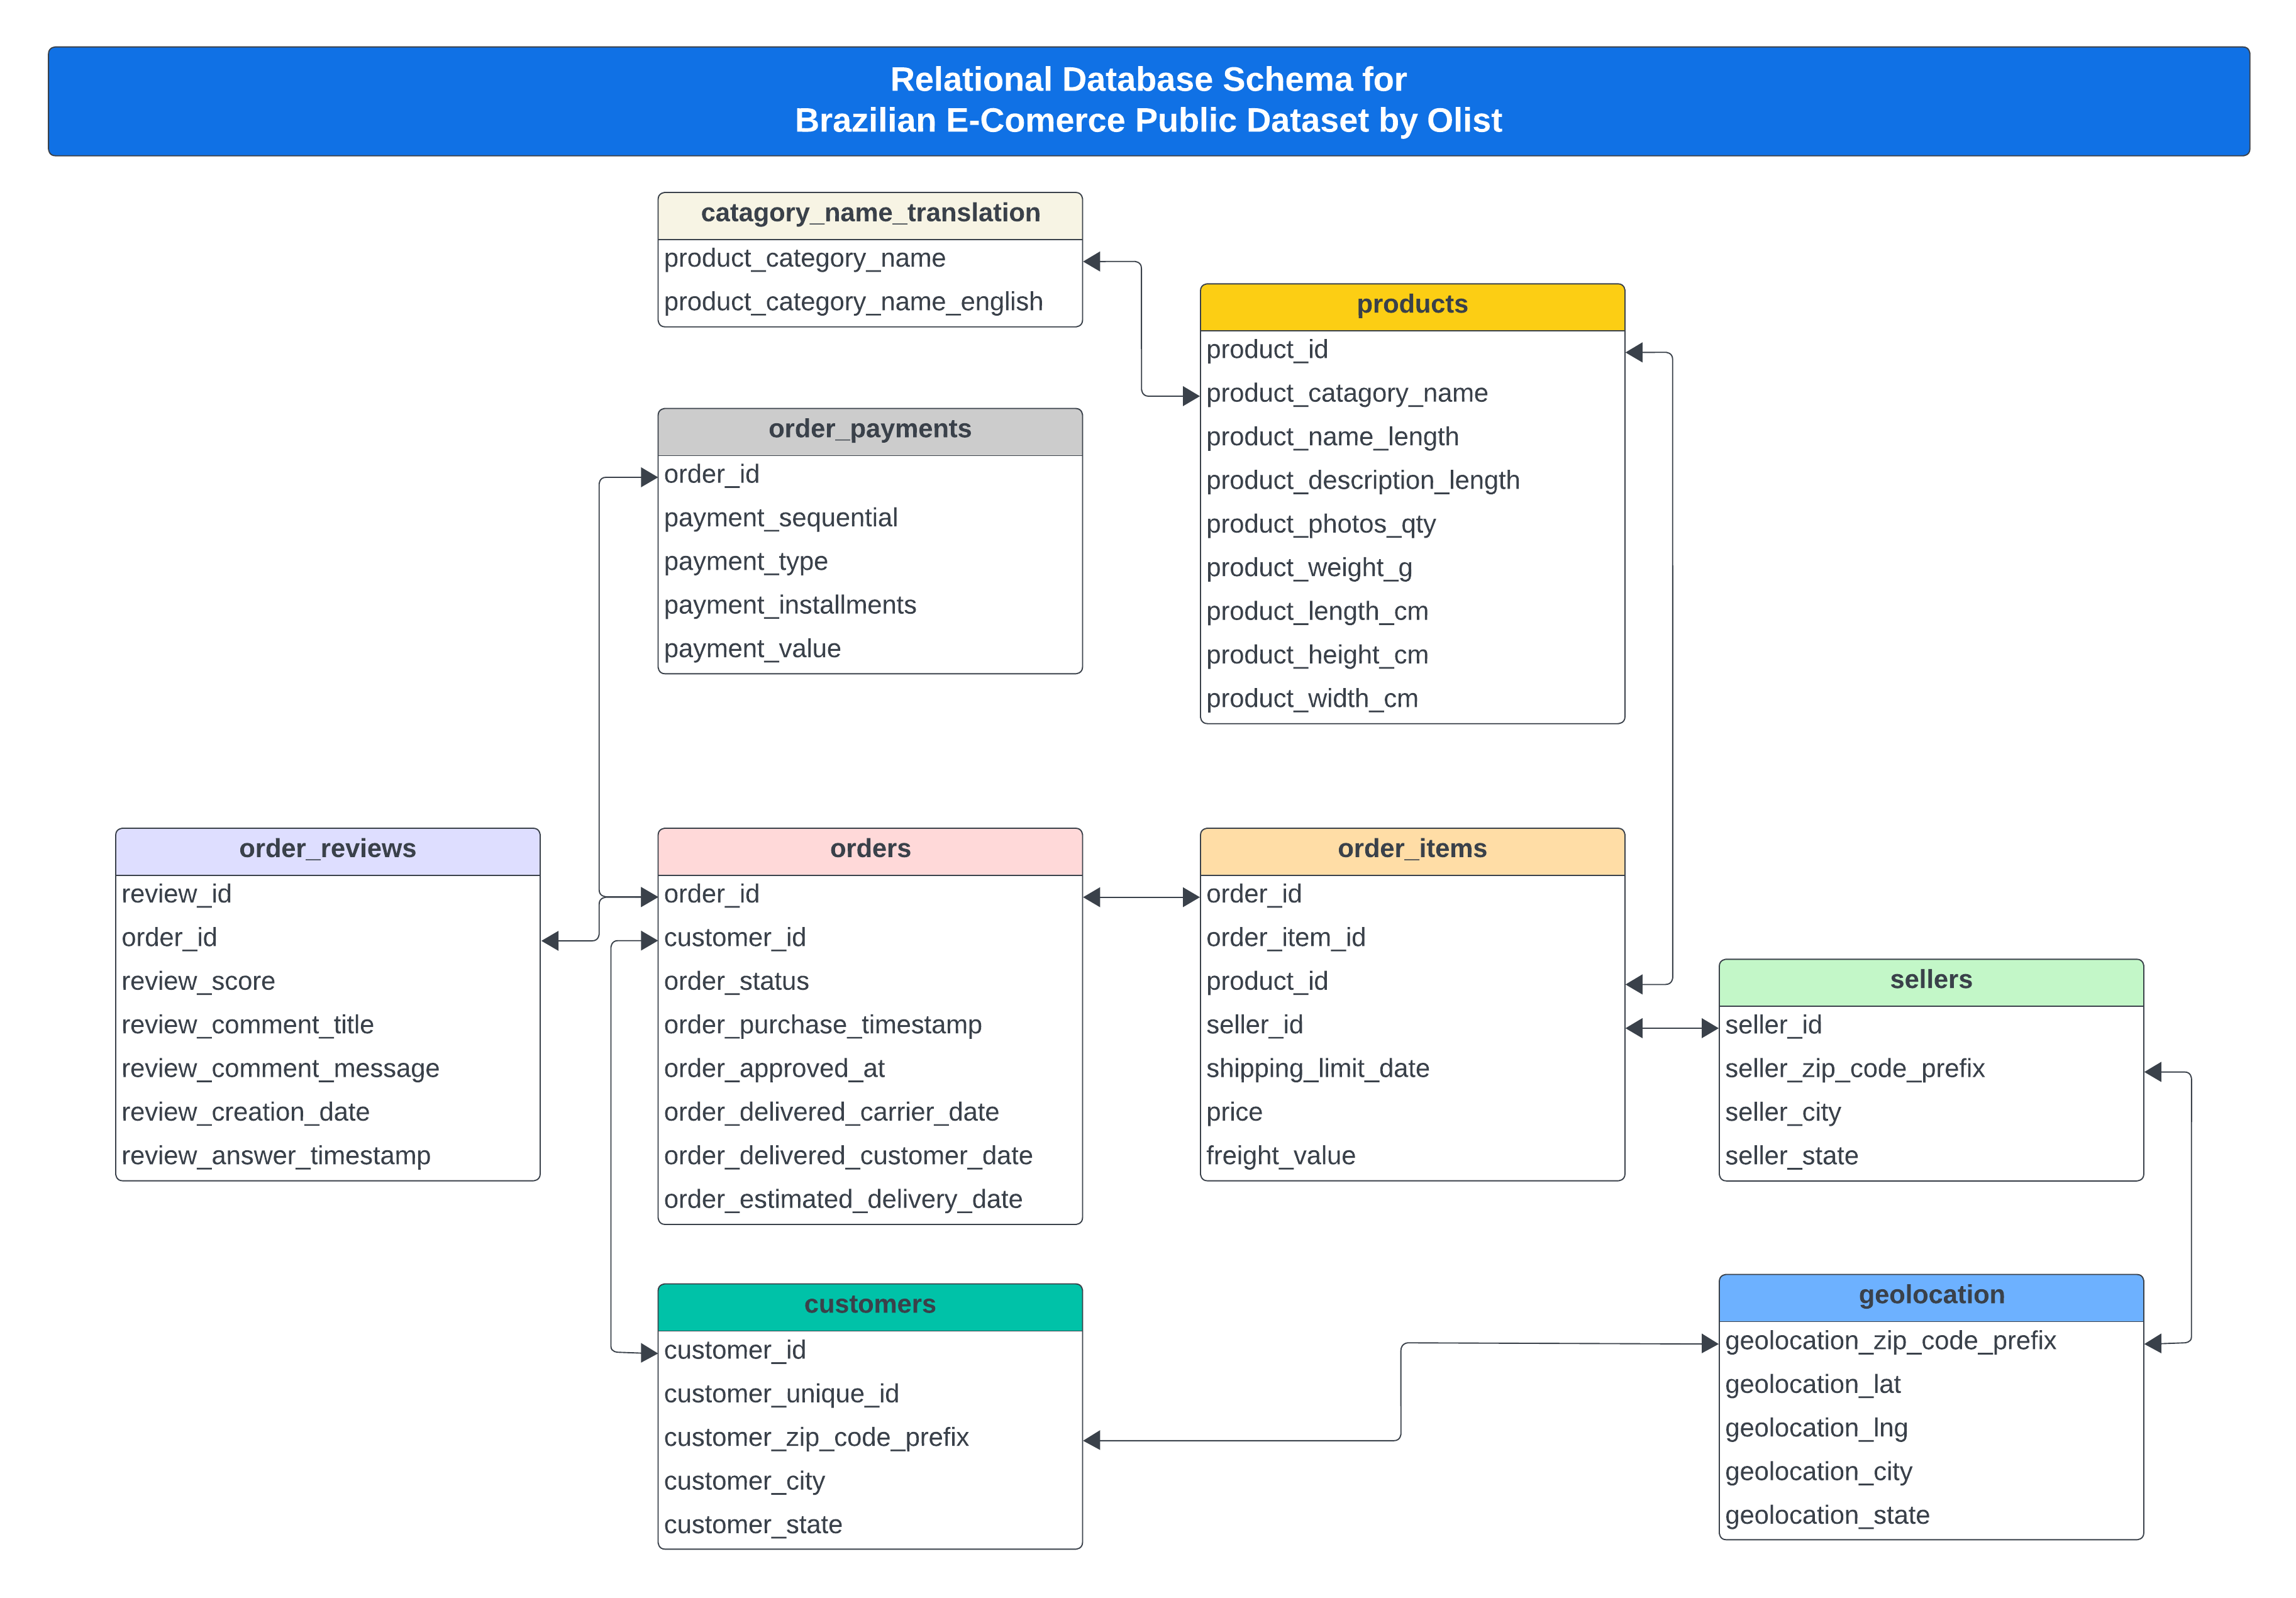

# Merging data


In [10]:
df_olist = pd.merge(df_olist_orders, df_olist_order_items, on='order_id', how='left')
df_olist = pd.merge(df_olist, df_olist_products, on='product_id', how='inner')
df_olist = pd.merge(df_olist, df_olist_order_payments, on='order_id', how = 'left')
df_olist = pd.merge(df_olist, df_olist_order_reviews, on='order_id', how='left')
df_olist = pd.merge(df_olist, df_olist_customers, on='customer_id', how='right')
df_olist = pd.merge(df_olist, df_product_category_name_translation, on='product_category_name', how='inner')

df_olist.shape

(116576, 37)

In [11]:
df_olist.head()

order_id                       customer_id  \
0  00e7ee1b050b8499577073aeb2a297a1  06b8999e2fba1a1fbc88172c00ba8bc7   
1  29150127e6685892b6eab3eec79f59c7  18955e83d337fd6b2def6b18a428ac77   
2  b2059ed67ce144a36e2aa97d2c9e9ad2  4e7b3e00288586ebd08712fdd0374a03   
3  951670f92359f4fe4a63112aa7306eba  b2b6027bc5c5109e529d4dc6358b12c3   
4  6b7d50bd145f6fc7f33cebabd7e49d0f  4f2d8ab171c80ec8364f7c12e35b23ad   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-05-16 15:05:35  2017-05-16 15:22:12   
1    delivered      2018-01-12 20:48:24  2018-01-12 20:58:32   
2    delivered      2018-05-19 16:07:45  2018-05-20 16:19:10   
3    delivered      2018-03-13 16:06:38  2018-03-13 17:29:19   
4    delivered      2018-07-29 09:51:30  2018-07-29 10:10:09   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-05-23 10:47:57           2017-05-25 10:35:35   
1          2018-01-15 17:14:59           2018-01-29 12:41:19   
2          2018-06-11 14:31:00           2018-06-14 17:58:51   
3          2018-03-27 23:22:42           2018-03-28 16:04:25   
4          2018-07-30 15:16:00           2018-08-09 20:55:48   

  order_estimated_delivery_date  order_item_id  \
0           2017-06-05 00:00:00            1.0   
1           2018-02-06 00:00:00            1.0   
2           2018-06-13 00:00:00            1.0   
3           2018-04-10 00:00:00            1.0   
4           2018-08-15 00:00:00            1.0   

                         product_id                         seller_id  \
0  a9516a079e37a9c9c36b9b78b10169e8  7c67e1448b00f6e969d365cea6b010ab   
1  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
2  bd07b66896d6f1494f5b86251848ced7  7c67e1448b00f6e969d365cea6b010ab   
3  a5647c44af977b148e0a3a4751a09e2e  7c67e1448b00f6e969d365cea6b010ab   
4  9391a573abe00141c56e38d84d7d5b3b  4a3ca9315b744ce9f8e9374361493884   

   shipping_limit_date   price  freight_value  product_category_name  \
0  2017-05-22 15:22:12  124.99          21.88      moveis_escritorio   
1  2018-01-18 20:58:32  289.00          46.48  utilidades_domesticas   
2  2018-06-05 16:19:10  139.94          17.79      moveis_escritorio   
3  2018-03-27 16:31:16  149.94          23.36      moveis_escritorio   
4  2018-07-31 10:10:09  230.00          22.25          casa_conforto   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 41.0                      1141.0                 1.0   
1                 43.0                      1002.0                 3.0   
2                 55.0                       955.0                 1.0   
3                 48.0                      1066.0                 1.0   
4                 61.0                       407.0                 1.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0            8683.0               54.0               64.0              31.0   
1           10150.0               89.0               15.0              40.0   
2            8267.0               52.0               52.0              17.0   
3           12160.0               56.0               51.0              28.0   
4            5200.0               45.0               15.0              35.0   

   payment_sequential payment_type  payment_installments  payment_value  \
0                 1.0  credit_card                   2.0         146.87   
1                 1.0  credit_card                   8.0         335.48   
2                 1.0  credit_card                   7.0         157.73   
3                 1.0  credit_card                   1.0         173.30   
4                 1.0  credit_card                   8.0         252.25   

                          review_id  review_score review_comment_title  \
0  88b8b52d46df026a9d1ad2136a59b30b           4.0                  NaN   
1  02fc48a9efa3e3d0f1a8ea26507eeec3           5.0                  NaN   
2  5ad6695d76ee186dc473c42706984d87           5.0   

In [12]:
def display_columns_info(df):
    columns_info = []
    for col in df.columns:
        null_count = df[col].isnull().sum()
        data_type = df[col].dtype
        rows_with_values = df[col].notnull().sum()
        columns_info.append([col, null_count, data_type, rows_with_values])

    columns_info_df = pd.DataFrame(columns_info, columns=['Column Name', 'Null Amount', 'Data Type', 'Number of Rows '])
    return columns_info_df

display_columns_info(df_olist)

Column Name  Null Amount Data Type  Number of Rows 
0                        order_id            0    object           116576
1                     customer_id            0    object           116576
2                    order_status            0    object           116576
3        order_purchase_timestamp            0    object           116576
4               order_approved_at           14    object           116562
5    order_delivered_carrier_date         1213    object           115363
6   order_delivered_customer_date         2515    object           114061
7   order_estimated_delivery_date            0    object           116576
8                   order_item_id            0   float64           116576
9                      product_id            0    object           116576
10                      seller_id            0    object           116576
11            shipping_limit_date            0    object           116576
12                          price            0   float64           116576
13                  freight_value            0   float64           116576
14          product_category_name            0    object           116576
15            product_name_lenght            0   float64           116576
16     product_description_lenght            0   float64           116576
17             product_photos_qty            0   float64           116576
18               product_weight_g            1   float64           116575
19              product_length_cm            1   float64           116575
20              product_height_cm            1   float64           116575
21               product_width_cm            1   float64           116575
22             payment_sequential            3   float64           116573
23                   payment_type            3    object           116573
24           payment_installments            3   float64           116573
25                  payment_value            3   float64           116573
26                      review_id          964    object           115612
27                   review_score          964   float64           115612
28           review_comment_title       102775    object            13801
29         review_comment_message        67667    object            48909
30           review_creation_date          964    object           115612
31        review_answer_timestamp          964    object           115612
32             customer_unique_id            0    object           116576
33       customer_zip_code_prefix            0     int64           116576
34                  customer_city            0    object           116576
35                 customer_state            0    object           116576
36  product_category_name_english            0    object           116576

In [13]:
quantity_of_orders = df_olist_orders['order_id'].nunique()
print(f'Zostało złożonych {quantity_of_orders} unikatowych zamówień')
df_olist.drop_duplicates(subset = 'order_id', inplace = True)
df_olist['order_id'].shape


Zostało złożonych 99441 unikatowych zamówień


(97256,)

# EDA


/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_8105/1135002442.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




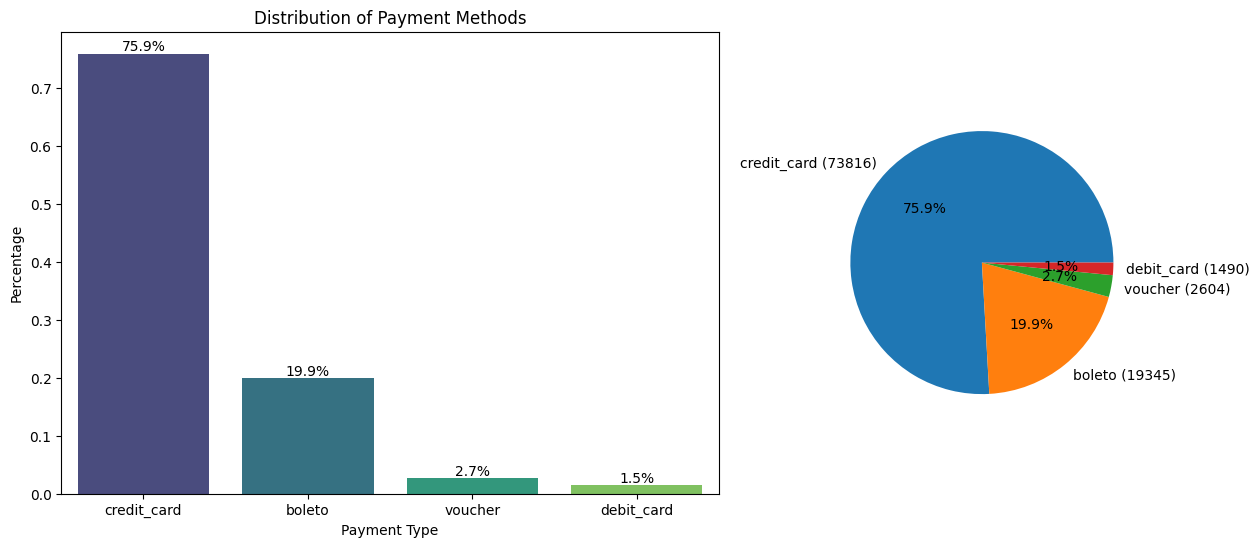

In [14]:
payment_met_counts = df_olist['payment_type'].value_counts().to_dict()
payment_met_percentages = df_olist['payment_type'].value_counts(normalize=True).reset_index()
payment_met_percentages.columns = ['Payment Type', 'Percentage']

# Ustawienia wykresu słupkowego
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

# Wykres słupkowy
ax0 = plt.subplot(gs[0])
sns.barplot(x='Payment Type', y='Percentage', data=payment_met_percentages, palette='viridis', ax=ax0)

# Dodanie etykiet z procentami na słupkach
for p in ax0.patches:
    ax0.annotate(f"{p.get_height()*100:.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

ax0.set_xlabel('Payment Type')
ax0.set_ylabel('Percentage')
ax0.set_title('Distribution of Payment Methods')

# Wykres kołowy
ax1 = plt.subplot(gs[1])
patches, texts, autotexts = ax1.pie(payment_met_counts.values(), labels=payment_met_counts.keys(), autopct='%1.1f%%', startangle=0)

# Dodanie liczby danych płatności obok etykiet
for text, autotext, count in zip(texts, autotexts, payment_met_counts.values()):
    text.set_text(f"{text.get_text()} ({count})")

ax1.set_title('')

# Pokazanie wykresu
plt.show()

/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_8105/2394711267.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




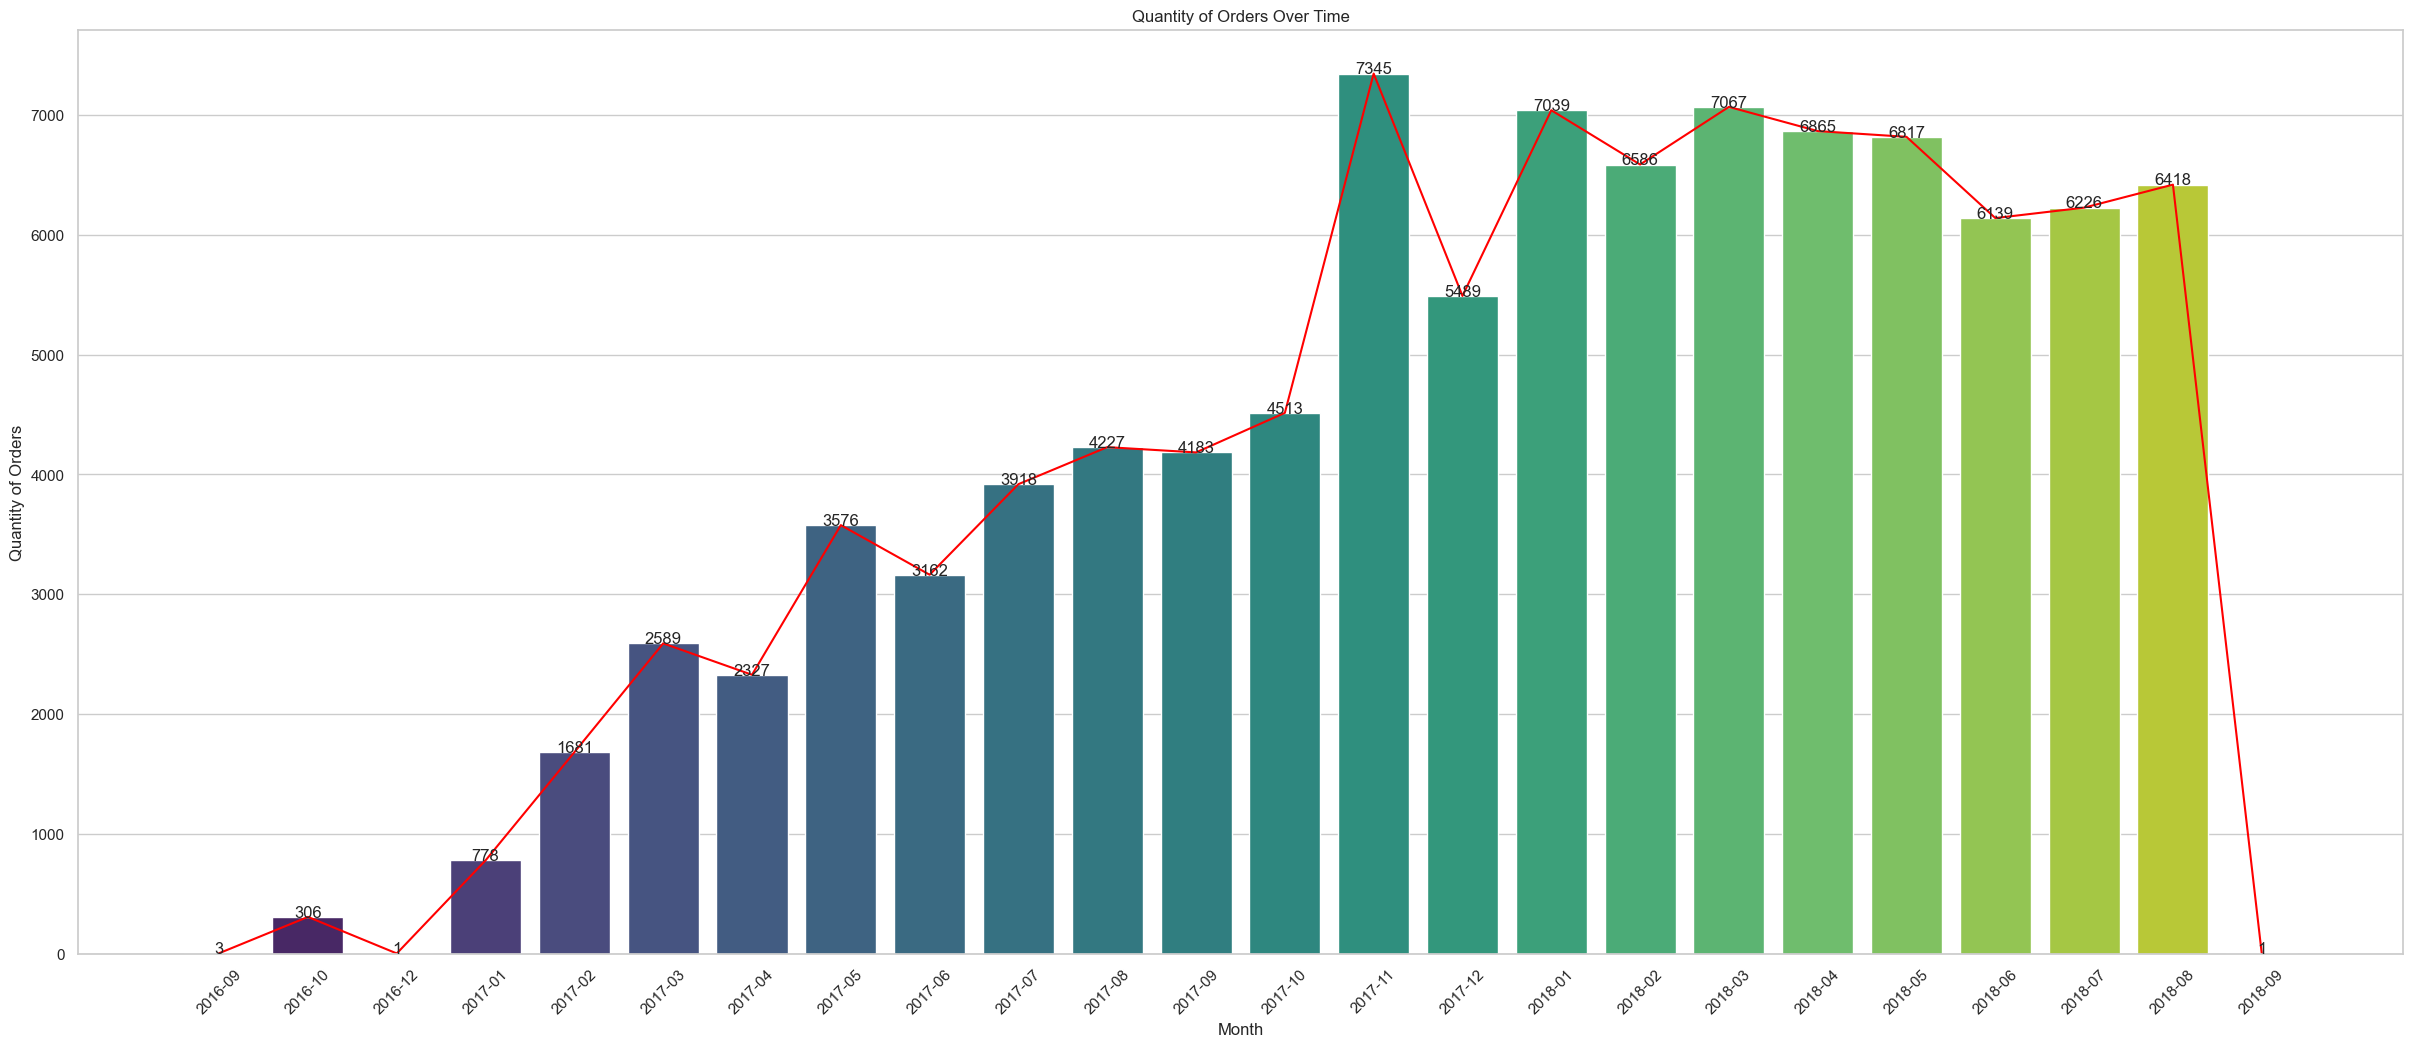

In [15]:
df_orders_quantity = df_olist[['order_purchase_timestamp', 'price']].dropna()
df_orders_quantity['quantity_of_orders'] = 1
df_orders_quantity['order_purchase_timestamp'] = pd.to_datetime(df_orders_quantity['order_purchase_timestamp'])
#sortuje dane względem daty
df_orders_quantity = df_orders_quantity.sort_values(by='order_purchase_timestamp')

# Format 'YYYY-MM'
df_orders_quantity['order_purchase_timestamp'] = df_orders_quantity['order_purchase_timestamp'].dt.to_period("M")

# pogrupowane i zsumowane zamówienia dla każdego miesiąca
df_orders_quantity = df_orders_quantity.groupby('order_purchase_timestamp').agg({'quantity_of_orders': 'sum'}).reset_index()
df_orders_quantity.rename(columns={'order_purchase_timestamp': 'Month', 'quantity_of_orders': 'Quantity of orders'}, inplace=True)

# 'Month' na string
df_orders_quantity['Month'] = df_orders_quantity['Month'].astype(str)

#  'Quantity of orders' na liczby
df_orders_quantity['Quantity of orders'] = pd.to_numeric(df_orders_quantity['Quantity of orders'], errors='coerce')

# styl wykresu
sns.set(style="whitegrid")

# wykres
plt.figure(figsize=(30, 12))
barplot = sns.barplot(x='Month', y='Quantity of orders', data=df_orders_quantity, palette='viridis')

# Dodaj linię czerwoną
sns.lineplot(x='Month', y='Quantity of orders', data=df_orders_quantity, color='red', ax=barplot)

#oznaczenia nad słupkami
x = df_orders_quantity['Month']
y = df_orders_quantity['Quantity of orders']

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

# etykiety i tytuł
addlabels(x,y)
plt.xlabel('Month')
plt.ylabel('Quantity of Orders')
plt.title('Quantity of Orders Over Time')
plt.xticks(rotation=45)
plt.show()

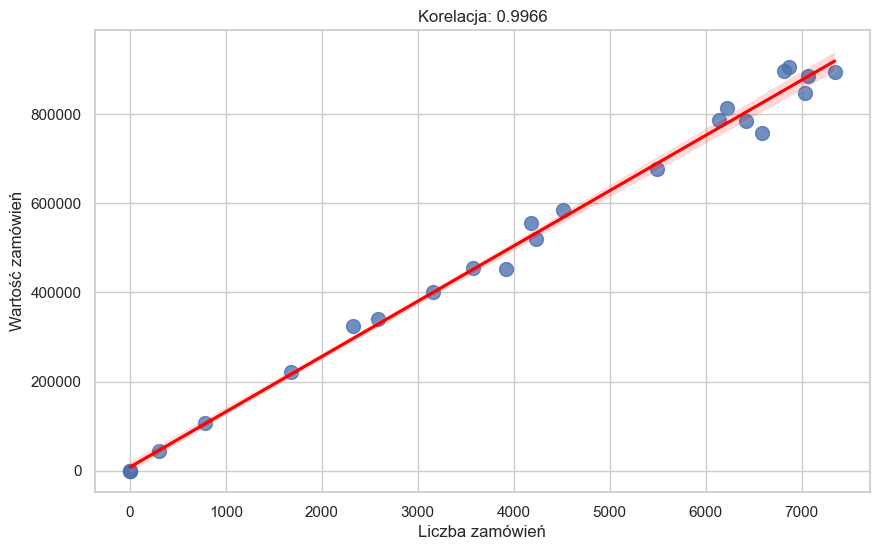

Średnia wartość koszyka zakupowego wynosi: 120.68


Month  Quantity of orders    Revenue  Avredge shopping cart
0   2016-09                   3     144.48                  48.16
1   2016-10                 306   45094.70                 147.37
2   2016-12                   1      10.90                  10.90
3   2017-01                 778  106697.11                 137.14
4   2017-02                1681  220794.12                 131.35
5   2017-03                2589  341176.15                 131.78
6   2017-04                2327  324215.97                 139.33
7   2017-05                3576  455177.32                 127.29
8   2017-06                3162  400210.88                 126.57
9   2017-07                3918  451617.05                 115.27
10  2017-08                4227  519891.13                 122.99
11  2017-09                4183  555014.24                 132.68
12  2017-10                4513  584993.48                 129.62
13  2017-11                7345  894435.46                 121.77
14  2017-12                5489  677387.71                 123.41
15  2018-01                7039  846642.74                 120.28
16  2018-02                6586  758478.50                 115.17
17  2018-03                7067  885975.25                 125.37
18  2018-04                6865  905849.82                 131.95
19  2018-05                6817  896305.38                 131.48
20  2018-06                6139  787775.92                 128.32
21  2018-07                6226  813915.76                 130.73
22  2018-08                6418  785272.81                 122.35
23  2018-09                   1     145.00                 145.00

In [16]:
df_revenue = df_olist[['price', 'order_purchase_timestamp']]
df_revenue.rename(columns={'order_purchase_timestamp':'Month','quantity of orders	':'Quantity of orders	','price':'Revenue'}, inplace = True)

df_revenue['Month'] = df_revenue['Month'].str.slice(stop=7)
df_revenue['Quantity of orders'] = 1

df_revenue['Month'] = pd.to_datetime(df_revenue['Month'], format='%Y-%m')

# Grupuj według miesiąca i podlicz ilość zamówień i wartość zamówień
df_revenue = df_revenue.groupby(df_revenue['Month'].dt.to_period("M")).agg(
    {'Quantity of orders': 'sum', 'Revenue': 'sum'}).reset_index()

df_revenue.head(20)

correlation = df_revenue['Quantity of orders'].corr(df_revenue['Revenue'])
# Stwórz wykres punktowy z linią trendu
plt.figure(figsize=(10, 6))
sns.regplot(x='Quantity of orders', y='Revenue', data=df_revenue, scatter_kws={'s': 100}, line_kws={'color': 'red'})
#plt.scatter(df_revenue['Quantity of orders'], df_revenue['Revenue'])
plt.title(f'Korelacja: {correlation:.4f}')
plt.xlabel('Liczba zamówień')
plt.ylabel('Wartość zamówień')
plt.grid(True)
plt.show()


df_revenue['Avredge shopping cart'] = round( df_revenue['Revenue'] / df_revenue['Quantity of orders'] ,2)
avredge_value_of_shoppint_cart =round(df_revenue['Avredge shopping cart']. mean(), 2)
print(f'Średnia wartość koszyka zakupowego wynosi: {avredge_value_of_shoppint_cart}')
df_revenue.head(30)



/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_8105/3802319267.py:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




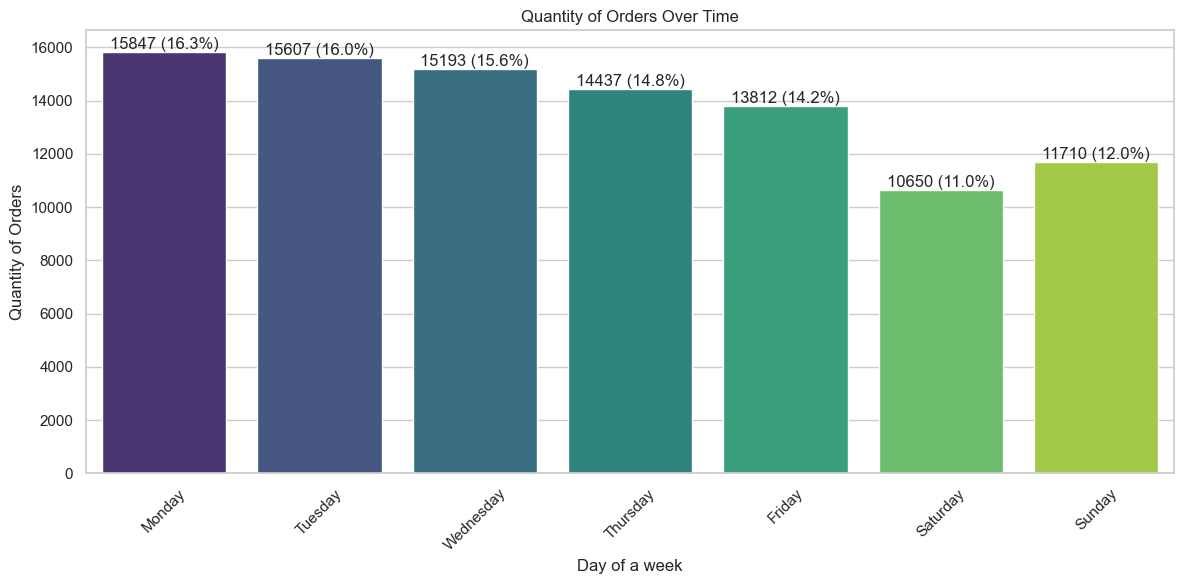

In [17]:
#new dataframe
df_daytime = df_olist[['order_id', 'order_purchase_timestamp']]
df_daytime['order_purchase_timestamp'] = pd.to_datetime(df_daytime['order_purchase_timestamp'])
df_daytime['year'] = df_daytime['order_purchase_timestamp'].dt.year
df_daytime['month'] = df_daytime['order_purchase_timestamp'].dt.month
df_daytime['day'] = df_daytime['order_purchase_timestamp'].dt.day
df_daytime['month_name'] = df_daytime['order_purchase_timestamp'].dt.strftime('%B')
df_daytime['day_name'] = df_daytime['order_purchase_timestamp'].dt.strftime('%A')
df_daytime['day_of_week'] = (df_daytime['order_purchase_timestamp'].dt.dayofweek + 1)
df_daytime['hour'] = df_daytime['order_purchase_timestamp'].dt.hour
df_daytime['timeday'] = pd.cut(df_daytime['order_purchase_timestamp'].dt.hour, bins = [0,6,12,18,24], labels = ['Dawn', 'Morning' , 'Afternoon', 'Night'])
df_daytime.head(20)

#selected columns for bar plots
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week = df_daytime.groupby('day_name')['order_id'].nunique().sort_values(ascending=False).reindex(days_order)

#oznaczenia nad słupkami
x = day_of_week.index
y = day_of_week.values
#plot
sns.set(style="whitegrid")
sns.set_palette('viridis')
# wykres
plt.figure(figsize=(12,6))
dow_plot = sns.barplot(x=x, y=y, palette = 'viridis')



def addlabels(x,y):
    for i in range(len(x)):
         plt.text(i, y[i], f"{y[i]} ({y[i]/sum(y)*100:.1f}%)", ha='center', va='bottom')

# etykiety i tytuł
addlabels(x,y)
plt.xlabel('Day of a week')
plt.xlabel('Day of a week')
plt.ylabel('Quantity of Orders')
plt.title('Quantity of Orders Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_8105/965619059.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



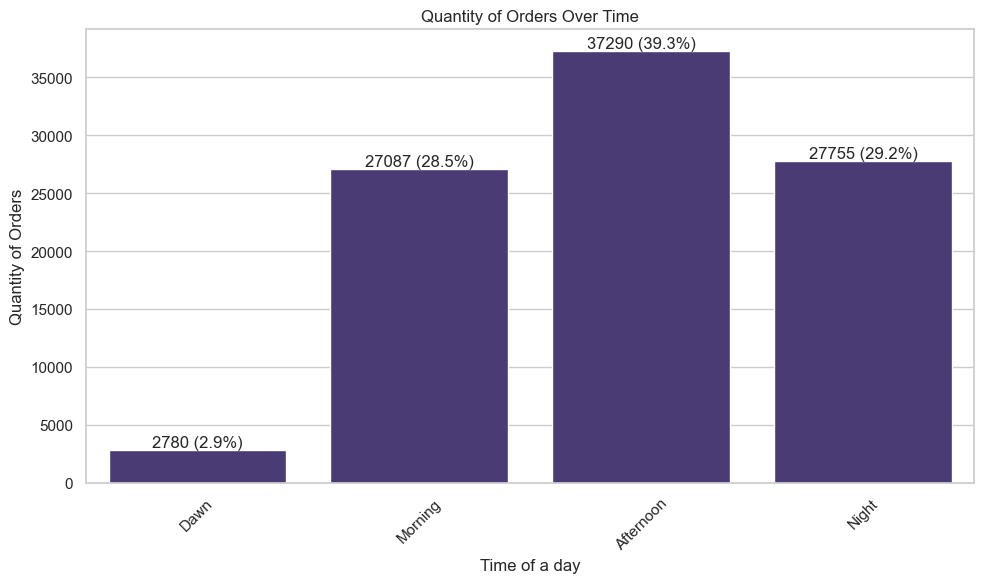

timeday
Dawn          2780
Morning      27087
Afternoon    37290
Night        27755
Name: order_id, dtype: int64


In [18]:
time_of_day = df_daytime.groupby('timeday')['order_id'].nunique()

#plot
sns.set(style="whitegrid")
sns.set_palette('viridis')

#oznaczenia nad słupkami
x = time_of_day.index
y = time_of_day.values

# wykres
plt.figure(figsize=(10, 6))
tod_plot = sns.barplot(x=x, y=y)

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], f"{y[i]} ({y[i]/sum(y)*100:.1f}%)", ha='center', va='bottom')

# etykiety i tytuł
addlabels(x,y)
plt.xlabel('Time of a day')
plt.ylabel('Quantity of Orders')
plt.title('Quantity of Orders Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print(time_of_day)

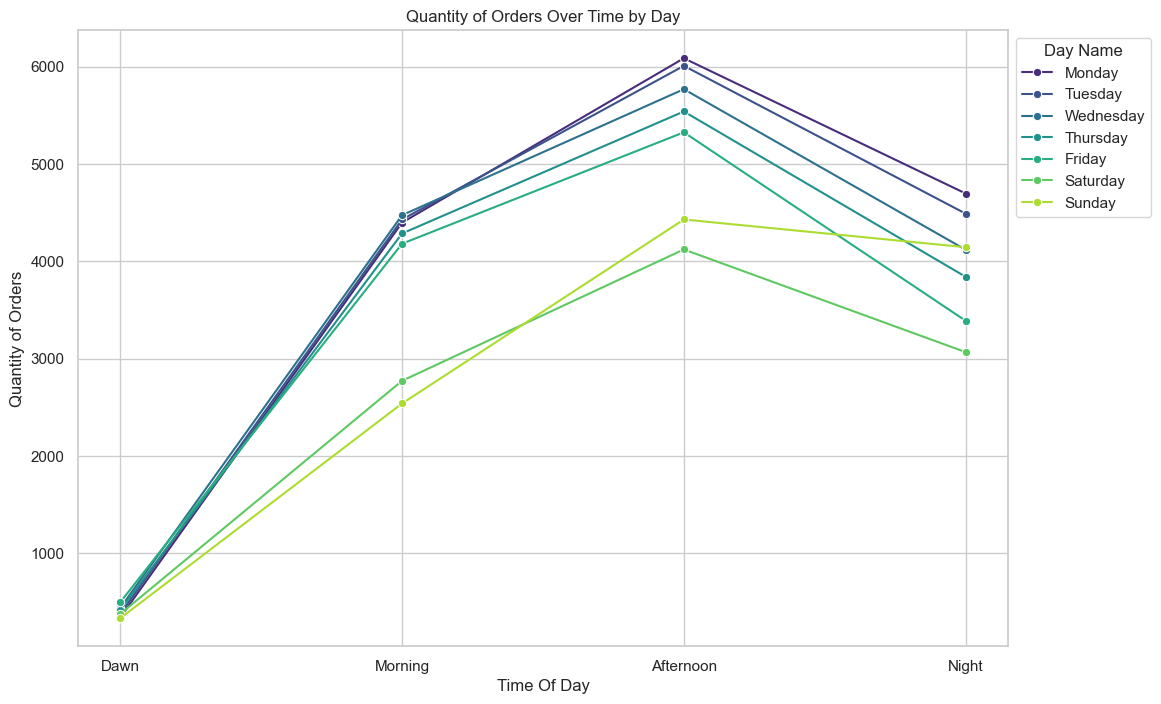

In [19]:
df_weekly = df_daytime[['order_id','day_name','timeday','day', ]]
df_weekly['Combined'] = df_weekly['day_name'].str.cat(df_weekly['timeday'], sep=' ')
df_weekly_combined = df_weekly.groupby('Combined')[['order_id']].nunique().reset_index().rename(columns={'order_id':'Quantity of orders'})
df_weekly_combined[['Day Name', 'Time Of Day']] = df_weekly_combined['Combined'].str.split(expand = True, n=1)

sort_days = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
sort_time = {'Dawn':1, 'Morning':2, 'Afternoon':3, 'Night':4}

df_weekly_combined['Sort by day'] = df_weekly_combined['Day Name'].map(sort_days)
df_weekly_combined['Sort by time'] = df_weekly_combined['Time Of Day'].map(sort_time)

df_weekly_combined.sort_values(by=["Sort by day", "Sort by time"],ascending=True, inplace = True)
df_weekly_combined.drop(columns=["Sort by day", "Sort by time"], inplace = True)

# Przygotowanie danych
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
time_order = ['Dawn', 'Morning', 'Afternoon', 'Night']

# Wybierz tylko odpowiednie dni i porę doby
df_plot = df_weekly_combined[df_weekly_combined['Day Name'].isin(days_order)]
df_plot = df_plot[df_plot['Time Of Day'].isin(time_order)]

# Ustawienie kolejności kategorii na osiach
sns.set(style="whitegrid")
palette = sns.color_palette("viridis", n_colors=len(days_order))

# Tworzenie wykresu
plt.figure(figsize=(12, 8))
sns.lineplot(x='Time Of Day', y='Quantity of orders', hue='Day Name', data=df_plot, palette=palette, marker='o')

# Dostosowanie etykiet osi i tytułu
plt.xlabel('Time Of Day')
plt.ylabel('Quantity of Orders')
plt.title('Quantity of Orders Over Time by Day')

# Legenda
plt.legend(title='Day Name', bbox_to_anchor=(1, 1), loc='upper left')

# Pokazanie wykresu
plt.show()

<Figure size 1200x800 with 0 Axes>

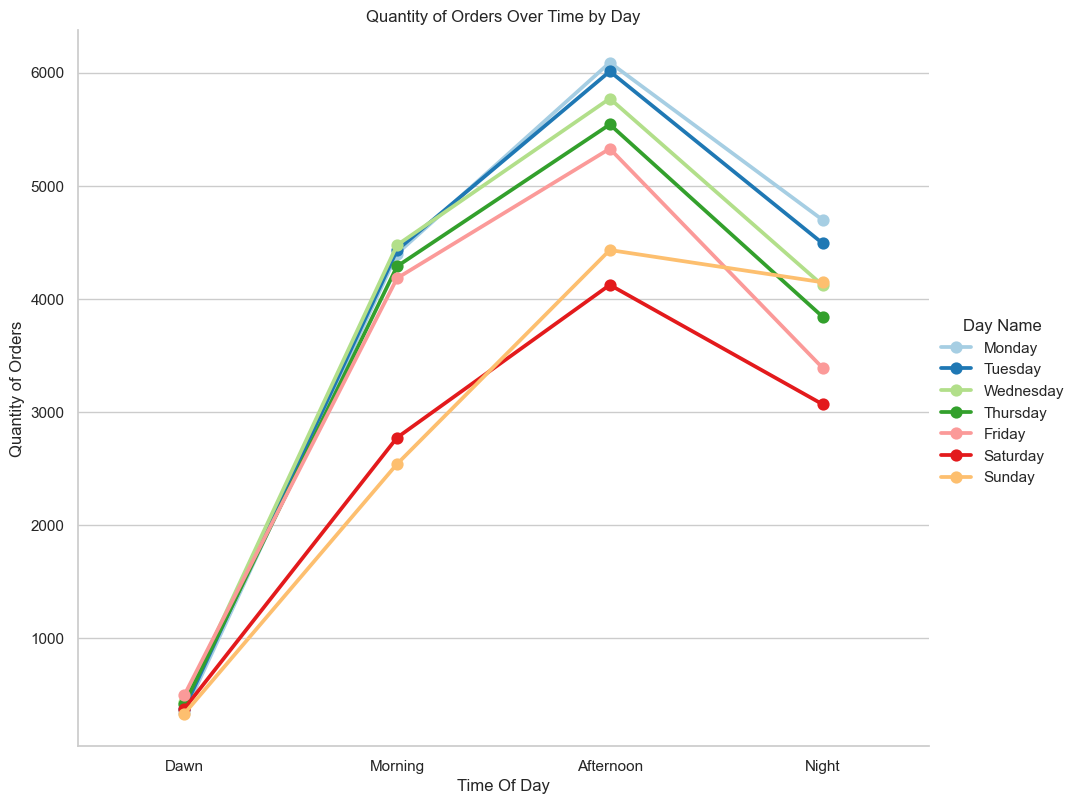

In [20]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
time_order = ['Dawn', 'Morning', 'Afternoon', 'Night']

# Wybierz tylko odpowiednie dni i porę doby
df_plot = df_weekly_combined[df_weekly_combined['Day Name'].isin(days_order)]
df_plot = df_plot[df_plot['Time Of Day'].isin(time_order)]

# Ustawienie kolejności kategorii na osiach
sns.set(style="whitegrid")
palette = sns.color_palette("Paired", n_colors=len(days_order))

# Tworzenie wykresu
plt.figure(figsize=(12, 8))
sns.catplot(x='Time Of Day', y='Quantity of orders', hue='Day Name', data=df_plot, kind='point', palette=palette, height=8, aspect=1.2)

# Dostosowanie etykiet osi i tytułu
plt.xlabel('Time Of Day')
plt.ylabel('Quantity of Orders')
plt.title('Quantity of Orders Over Time by Day')

# Legenda
#plt.legend(title='Day Name', bbox_to_anchor=(1, 1), loc='upper left')

# Pokazanie wykresu
plt.show()


/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_8105/952645007.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_8105/952645007.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_8105/952645007.py:25: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



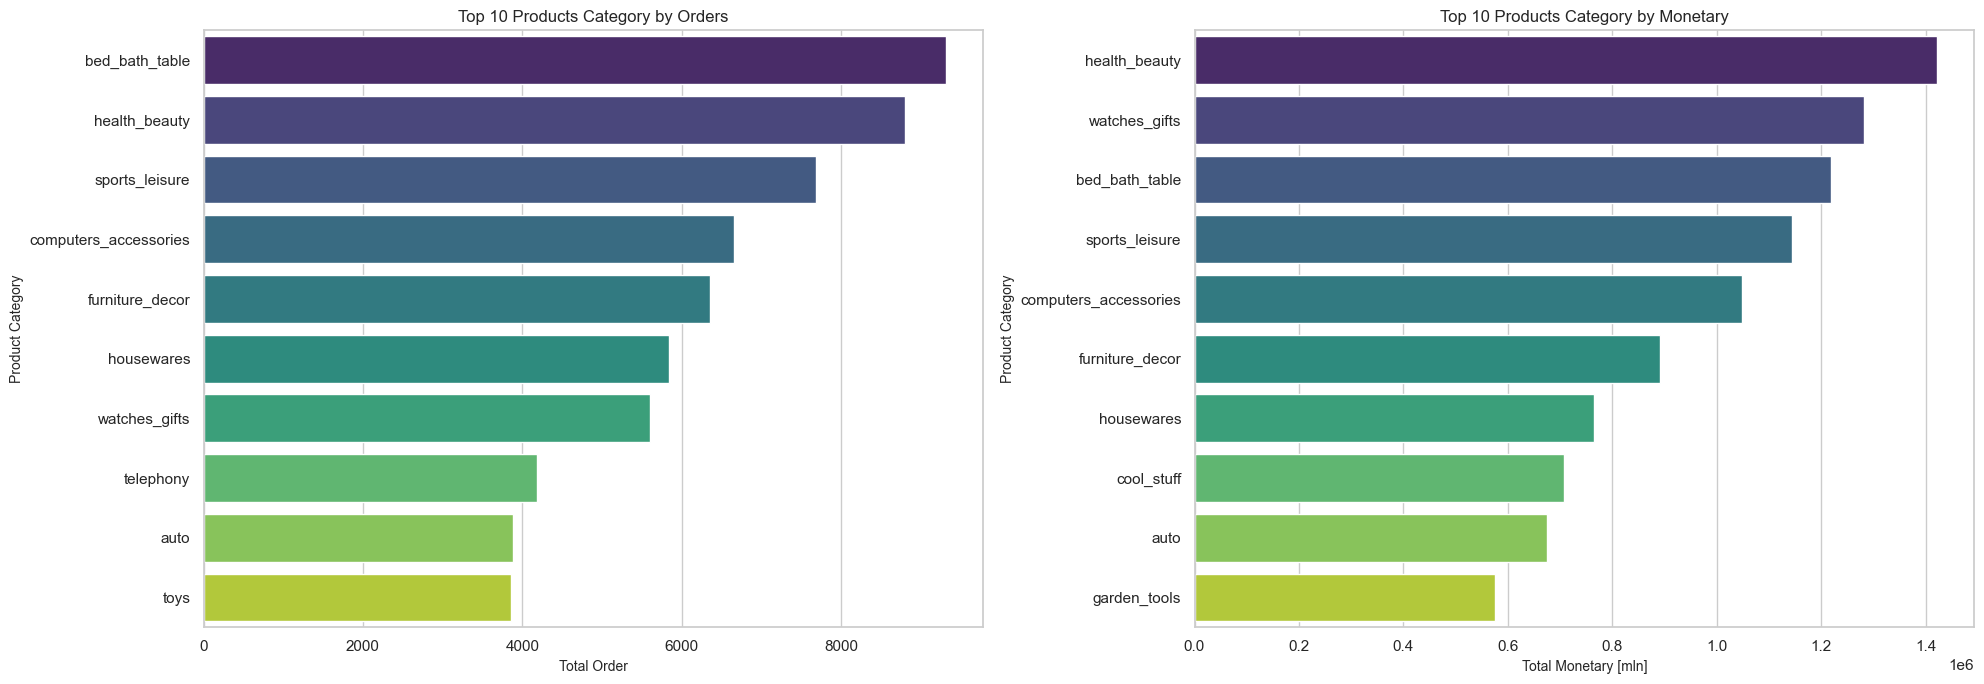

In [21]:
# Group by top 10 products category by Total Order and Total Monetary
products_by_order = df_olist.groupby('product_category_name_english').count()[['order_id']].sort_values(by='order_id', ascending=False).reset_index()[:10]
product_by_payment_value = df_olist.groupby('product_category_name_english').sum()[['payment_value']].sort_values(by='payment_value', ascending=False).reset_index()[:10]

sns.set(style="whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(20,7))

# Plot barplot [0]
sns.barplot(data=products_by_order, x='order_id', y='product_category_name_english', palette='viridis', ax=ax[0])
ax[0].set_title("Top 10 Products Category by Orders", fontdict={'fontsize':12})
ax[0].set_xlabel("Total Order", fontdict={'fontsize':10})
ax[0].set_ylabel("Product Category", fontdict={'fontsize':10})

# Plot barplot [1]
sns.barplot(data=product_by_payment_value, x='payment_value', y='product_category_name_english', palette="viridis", ax=ax[1])
ax[1].set_title("Top 10 Products Category by Monetary", fontdict={'fontsize':12})
ax[1].set_xlabel("Total Monetary [mln]", fontdict={'fontsize':10})
ax[1].set_ylabel("Product Category", fontdict={'fontsize':10})

# Make sure layout is not overlapping
fig.tight_layout()

# Show the graphs
fig.show()

In [22]:
# Group by the worst 10 products category by Total Order and Total Monetary
products_by_order = df_olist.groupby('product_category_name_english').count()[['order_id']].sort_values(by='order_id', ascending=True).reset_index()[:10]
product_by_payment_value = df_olist.groupby('product_category_name_english').sum()[['payment_value']].sort_values(by='payment_value', ascending=True).reset_index()[:10]

sns.set(style="whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(20,7))

# Plot barplot [0]
sns.barplot(data=products_by_order, x='order_id', y='product_category_name_english', palette='viridis', ax=ax[0])
ax[0].set_title("The worst 10 Products Category by Orders", fontdict={'fontsize':12})
ax[0].set_xlabel("Total Order", fontdict={'fontsize':10})
ax[0].set_ylabel("Product Category", fontdict={'fontsize':10})

# Plot barplot [1]
sns.barplot(data=product_by_payment_value, x='payment_value', y='product_category_name_english', palette="viridis", ax=ax[1])
ax[1].set_title("The worst 10 Products Category by Monetary", fontdict={'fontsize':12})
ax[1].set_xlabel("Total Monetary", fontdict={'fontsize':10})
ax[1].set_ylabel("Product Category", fontdict={'fontsize':10})

# Make sure layout is not overlapping
fig.tight_layout()

# Show the graphs
fig.show()

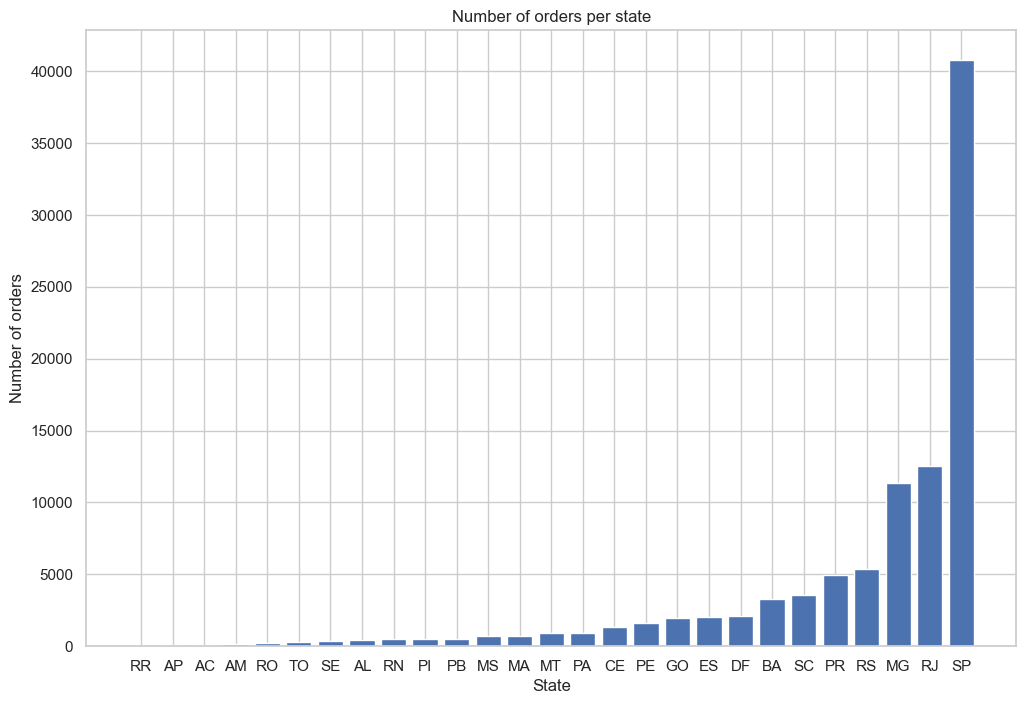

In [ ]:
customer_by_state = df_olist[['customer_unique_id', 'customer_state']].groupby('customer_state').count().reset_index()
customer_by_state = customer_by_state.sort_values(by=['customer_unique_id'])

plt.figure(figsize=(12,8))
plt.bar(customer_by_state['customer_state'], customer_by_state['customer_unique_id'])
plt.xlabel('State')
plt.ylabel('Number of orders')
plt.title('Number of orders per state')
plt.show()

In [ ]:
data = [go.Scattermapbox(
    lon = df_olist_geolocation['geolocation_lng'],
    lat = df_olist_geolocation['geolocation_lat'],
    text = df_olist_geolocation['geolocation_state'],
    marker = dict(
        size = 20,
        color = 'Tomato',
    ))]

layout = dict(
        title = 'Brazil State Recalculate Coordinate',
        mapbox = dict(
            accesstoken = 'pk.eyJ1IjoiZnJhYW5hcyIsImEiOiJjbHZlYWdhcTMwN2p2MmxsOTU4ZWQ2ZnplIn0.KpTd2M0AmkEtYD0Gka0wCQ',
            center= dict(lat=-22,lon=-43),
            bearing=10,
            pitch=0,
            zoom=2,
        )
    )
fig = dict( data=data, layout=layout )
iplot( fig, validate=False)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

# Kohorts


In [ ]:
df_segmentation_time = df_olist[['order_purchase_timestamp', 'customer_unique_id', 'order_id', 'price']]
# Konwertuję kolumnę 'order_purchase_timestamp' na format daty, następnie filtruje, aby DF zawierał tylko dane z okresu 1.1.2017 - 31.8.2018
df_segmentation_time['order_purchase_timestamp'] = pd.to_datetime(df_segmentation_time['order_purchase_timestamp'])
df_segmentation_time = df_segmentation_time[(df_segmentation_time['order_purchase_timestamp'] >= '2017-01-01')
& (df_segmentation_time['order_purchase_timestamp'] <= '2018-08-31')]

min_date = df_segmentation_time['order_purchase_timestamp'].min()
max_date = df_segmentation_time['order_purchase_timestamp'].max()
print(f"Najwcześniejsza data: {min_date}, Najnowsza data: {max_date}")

def display_null_counts(df):
    for col in df.columns:
      null_count = df[col].isnull().sum()
      print(f'Kolumna {col} ma {null_count} watości null.')
    print(f'Kształt DataFrame: {df.shape}')

display_null_counts(df_segmentation_time)

Najwcześniejsza data: 2017-01-05 11:56:06, Najnowsza data: 2018-08-29 15:00:37
Kolumna order_purchase_timestamp ma 0 watości null.
Kolumna customer_unique_id ma 0 watości null.
Kolumna order_id ma 0 watości null.
Kolumna price ma 0 watości null.
Kształt DataFrame: (96945, 4)


In [ ]:
#Wybieram kolumne z unikalnym ID klienta aby sprawdzić ilu ich jest oraz obliczyć ile jest zamówień powracających.
unique_clientsID = df_segmentation_time['customer_unique_id'].nunique()
clientsID_in_DF = df_segmentation_time['customer_unique_id'].count()

multi_order_customers = df_segmentation_time['customer_unique_id'].duplicated(keep=False)
multi_order_orders = df_segmentation_time[multi_order_customers].shape[0]
percent = ((multi_order_orders / unique_clientsID)*100)
rounded = round(percent, 3)

print(f'Ogólna liczba ID klientów to : {clientsID_in_DF}.')
print(f'Liczba unikatowych ID to : {unique_clientsID}.')
print(f'Procent powracających klientów: {rounded} % ')
print(f'Liczba zamowien od klientów, którzy dokonali zamówienia ponad 1 raz: {multi_order_orders}')

Ogólna liczba ID klientów to : 96945.
Liczba unikatowych ID to : 93791.
Procent powracających klientów: 6.387 % 
Liczba zamowien od klientów, którzy dokonali zamówienia ponad 1 raz: 5990


In [ ]:
#Zostawiam tylko zduplikowane wiersze z 'customer_unique_id' ponieważ są to klienci, którzy zrobili zamówienie więcej niż 1 raz
multi_order_customers = df_segmentation_time['customer_unique_id'].value_counts() > 1
multi_order_customers = multi_order_customers[multi_order_customers].index
df_seg_time = df_segmentation_time[df_segmentation_time['customer_unique_id'].isin(multi_order_customers)]


def get_month(x) :
   return dt.datetime(x.year, x.month, 1)

# Tworzę nową kolumnę 'OrderMonth', która zawiera pierwszy dzień miesiąca z kolumny 'order_purchase_timestamp'
df_seg_time['OrderMonth'] = df_seg_time['order_purchase_timestamp'].apply(get_month)
# Grupuję dane według 'customer_unique_id' i wybieram najwcześniejszy 'OrderMonth' dla każdego klienta
grouping = df_seg_time.groupby('customer_unique_id')['OrderMonth']
df_seg_time['AcquisitionMonth'] = grouping.transform('min')

df_seg_time.shape

(5990, 6)

In [ ]:
def get_date_int (df, column):
  year = df[column].dt.year
  month = df[column].dt.month
  day = df[column].dt.day
  return year, month, day

order_year, order_month, _ = get_date_int(df_seg_time, 'OrderMonth')
acqusiition_year, acqusiition_month, _ = get_date_int(df_seg_time, 'AcquisitionMonth')
# Obliczam różnice w latach i miesiącach między 'OrderMonth' i 'AcquisitionMonth'
years_diff = order_year - acqusiition_year
months_diff = order_month - acqusiition_month
# Obliczam indeks kohorty, przekształcając różnice w latach i miesiącach na liczbę miesięcy i dodając 1, aby uzyskać indeks kohorty
df_seg_time['CohortIndex'] = years_diff * 12 + months_diff + 1

grouping = df_seg_time.groupby(['AcquisitionMonth', 'CohortIndex'])
# Tworzę DataFrame `cohort_counts`, w którym wartości z kolumny 'customer_unique_id' są przekształcane  w liczbę klientów w kohorcie. Wiersze reprezentują kolejne miesiące pozyskania klientów,
# a kolumny reprezentują kolejne miesiące od pozyskania.
cohort_data = grouping['customer_unique_id'].apply(pd.Series.nunique).reset_index()
cohort_counts = cohort_data.pivot(index= 'AcquisitionMonth',
                                  columns = 'CohortIndex',
                                  values = 'customer_unique_id')
cohort_counts


CohortIndex          1     2     3     4     5     6     7     8     9     10  \
AcquisitionMonth                                                                
2017-01-01         53.0   3.0   2.0   1.0   3.0   1.0   3.0   1.0   NaN   NaN   
2017-02-01         66.0   4.0   5.0   1.0   7.0   2.0   4.0   3.0   2.0   3.0   
2017-03-01        125.0  13.0   9.0   9.0   9.0   4.0   4.0   8.0   9.0   2.0   
2017-04-01        105.0  14.0   5.0   4.0   8.0   6.0   7.0   7.0   7.0   4.0   
2017-05-01        186.0  17.0  16.0  13.0  11.0  12.0  15.0   5.0   8.0   9.0   
2017-06-01        168.0  15.0  11.0  12.0   8.0  12.0  11.0   7.0   4.0   6.0   
2017-07-01        177.0  20.0  13.0   9.0  10.0   8.0  12.0   4.0   7.0  10.0   
2017-08-01        187.0  27.0  14.0  11.0  15.0  21.0  12.0  10.0   6.0   6.0   
2017-09-01        185.0  27.0  20.0  12.0  18.0   8.0   9.0  10.0  12.0   8.0   
2017-10-01        165.0  30.0  11.0   3.0  10.0   9.0  10.0  16.0  12.0   9.0   
2017-11-01        224.0  39.0  28.0  12.0  13.0  12.0   8.0  14.0   9.0   4.0   
2017-12-01        141.0  11.0  15.0  18.0  14.0  11.0   8.0   1.0  12.0   NaN   
2018-01-01        212.0  23.0  26.0  20.0  20.0  11.0  12.0  15.0   NaN   NaN   
2018-02-01        237.0  24.0  25.0  19.0  17.0  14.0  11.0   NaN   NaN   NaN   
2018-03-01        169.0  31.0  22.0  20.0   9.0   8.0   NaN   NaN   NaN   NaN   
2018-04-01        130.0  39.0  20.0  16.0   8.0   NaN   NaN   NaN   NaN   NaN   
2018-05-01        114.0  35.0  18.0  14.0   NaN   NaN   NaN   NaN   NaN   NaN   
2018-06-01         70.0  25.0  15.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2018-07-01         88.0  29.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2018-08-01         34.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

CohortIndex         11    12   13    14   15   16   17   18   20  
AcquisitionMonth                                                  
2017-01-01         3.0   1.0  4.0   3.0  1.0  1.0  2.0  3.0  1.0  
2017-02-01         2.0   5.0  2.0   3.0  2.0  1.0  1.0  4.0  NaN  
2017-03-01         9.0   3.0  6.0   3.0  4.0  6.0  2.0  4.0  NaN  
2017-04-01         6.0   2.0  2.0   1.0  2.0  2.0  4.0  NaN  NaN  
2017-05-01         9.0  10.0  9.0   1.0  6.0  9.0  NaN  NaN  NaN  
2017-06-01        10.0  10.0  5.0   4.0  6.0  NaN  NaN  NaN  NaN  
2017-07-01         8.0  11.0  5.0  10.0  NaN  NaN  NaN  NaN  NaN  
2017-08-01        10.0   8.0  3.0   NaN  NaN  NaN  NaN  NaN  NaN  
2017-09-01        11.0   3.0  NaN   NaN  NaN  NaN  NaN  NaN  NaN  
2017-10-01         9.0   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  
2017-11-01         NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  
2017-12-01         NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  
2018-01-01         NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  
2018-02-01         NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  
2018-03-01         NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  
2018-04-01         NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  
2018-05-01         NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  
2018-06-01         NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  
2018-07-01         NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  
2018-08-01         NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN

In [ ]:
# Obliczam rozmiar kohorty jako liczby klientów w pierwszym miesiącu, następnie dziele każdy następny okres przed liczbę z pierwszego okresu
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis = 0)
retention.loc['2017-01-01'] = retention.loc['2017-01-01'].fillna(0)
retention.round(2)*100

CohortIndex          1     2     3     4     5     6    7     8    9    10  \
AcquisitionMonth                                                             
2017-01-01        100.0   6.0   4.0   2.0   6.0   2.0  6.0   2.0  0.0  0.0   
2017-02-01        100.0   6.0   8.0   2.0  11.0   3.0  6.0   5.0  3.0  5.0   
2017-03-01        100.0  10.0   7.0   7.0   7.0   3.0  3.0   6.0  7.0  2.0   
2017-04-01        100.0  13.0   5.0   4.0   8.0   6.0  7.0   7.0  7.0  4.0   
2017-05-01        100.0   9.0   9.0   7.0   6.0   6.0  8.0   3.0  4.0  5.0   
2017-06-01        100.0   9.0   7.0   7.0   5.0   7.0  7.0   4.0  2.0  4.0   
2017-07-01        100.0  11.0   7.0   5.0   6.0   5.0  7.0   2.0  4.0  6.0   
2017-08-01        100.0  14.0   7.0   6.0   8.0  11.0  6.0   5.0  3.0  3.0   
2017-09-01        100.0  15.0  11.0   6.0  10.0   4.0  5.0   5.0  6.0  4.0   
2017-10-01        100.0  18.0   7.0   2.0   6.0   5.0  6.0  10.0  7.0  5.0   
2017-11-01        100.0  17.0  12.0   5.0   6.0   5.0  4.0   6.0  4.0  2.0   
2017-12-01        100.0   8.0  11.0  13.0  10.0   8.0  6.0   1.0  9.0  NaN   
2018-01-01        100.0  11.0  12.0   9.0   9.0   5.0  6.0   7.0  NaN  NaN   
2018-02-01        100.0  10.0  11.0   8.0   7.0   6.0  5.0   NaN  NaN  NaN   
2018-03-01        100.0  18.0  13.0  12.0   5.0   5.0  NaN   NaN  NaN  NaN   
2018-04-01        100.0  30.0  15.0  12.0   6.0   NaN  NaN   NaN  NaN  NaN   
2018-05-01        100.0  31.0  16.0  12.0   NaN   NaN  NaN   NaN  NaN  NaN   
2018-06-01        100.0  36.0  21.0   NaN   NaN   NaN  NaN   NaN  NaN  NaN   
2018-07-01        100.0  33.0   NaN   NaN   NaN   NaN  NaN   NaN  NaN  NaN   
2018-08-01        100.0   NaN   NaN   NaN   NaN   NaN  NaN   NaN  NaN  NaN   

CohortIndex        11   12   13   14   15   16   17   18   20  
AcquisitionMonth                                               
2017-01-01        6.0  2.0  8.0  6.0  2.0  2.0  4.0  6.0  2.0  
2017-02-01        3.0  8.0  3.0  5.0  3.0  2.0  2.0  6.0  NaN  
2017-03-01        7.0  2.0  5.0  2.0  3.0  5.0  2.0  3.0  NaN  
2017-04-01        6.0  2.0  2.0  1.0  2.0  2.0  4.0  NaN  NaN  
2017-05-01        5.0  5.0  5.0  1.0  3.0  5.0  NaN  NaN  NaN  
2017-06-01        6.0  6.0  3.0  2.0  4.0  NaN  NaN  NaN  NaN  
2017-07-01        5.0  6.0  3.0  6.0  NaN  NaN  NaN  NaN  NaN  
2017-08-01        5.0  4.0  2.0  NaN  NaN  NaN  NaN  NaN  NaN  
2017-09-01        6.0  2.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2017-10-01        5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2017-11-01        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2017-12-01        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2018-01-01        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2018-02-01        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2018-03-01        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2018-04-01        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2018-05-01        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2018-06-01        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2018-07-01        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2018-08-01        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

In [ ]:
# Obliczam średnią wartość ceny dla każdej kohorty
grouping = df_seg_time.groupby(['AcquisitionMonth', 'CohortIndex' ])
cohort_data = grouping['price'].mean()
cohort_data = cohort_data.reset_index()
avrege_quantity = cohort_data.pivot(index = 'AcquisitionMonth',
                                    columns = 'CohortIndex',
                                    values = 'price')
avrege_quantity.round(1)


CohortIndex          1      2      3      4      5      6      7      8   \
AcquisitionMonth                                                           
2017-01-01         71.3   41.6   41.4   75.0   66.6   60.0   78.9   39.9   
2017-02-01         87.8  119.6   92.9   44.4  135.0   25.0   71.0   78.3   
2017-03-01        121.0   93.8  150.4  145.9  109.5  326.7  125.9   92.2   
2017-04-01        173.6  130.0  133.4  134.2  194.2  172.6  205.4   60.6   
2017-05-01        103.4   63.3  100.7   99.5   99.0   91.4  162.9  108.3   
2017-06-01        103.0  223.1   90.0   96.7   84.2  107.1   79.1   94.7   
2017-07-01         98.7  109.9   98.8   97.0   62.9  174.2  184.2   48.2   
2017-08-01         99.5  131.3   94.1   66.3   99.3  109.6  121.9   76.6   
2017-09-01        126.3   91.2  129.8   82.4  136.1   96.4   84.5   72.9   
2017-10-01         92.2   95.3  103.2  121.0   79.1   94.9   81.2  100.1   
2017-11-01        109.3  156.7  111.1   85.7  104.4  111.9   97.9   85.4   
2017-12-01        106.9  183.4   84.2   95.6  116.5  161.0  121.1  140.0   
2018-01-01        104.4  101.4  101.2  121.3  107.1  102.5   68.8   76.9   
2018-02-01         97.9  102.0   96.8  147.2   72.1  179.8  101.9    NaN   
2018-03-01         95.4  111.6  108.8  129.4  137.0   46.6    NaN    NaN   
2018-04-01        120.6  100.3  115.7   79.2   71.6    NaN    NaN    NaN   
2018-05-01        129.0  170.6   99.8  104.5    NaN    NaN    NaN    NaN   
2018-06-01         93.8   78.1   85.5    NaN    NaN    NaN    NaN    NaN   
2018-07-01        113.1   98.6    NaN    NaN    NaN    NaN    NaN    NaN   
2018-08-01        107.7    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

CohortIndex          9      10     11     12     13     14     15     16  \
AcquisitionMonth                                                           
2017-01-01          NaN    NaN  124.4   49.0   68.2   99.6   19.0   89.9   
2017-02-01        216.4   56.3  159.4   76.6  123.5   93.3   71.9  117.0   
2017-03-01        110.5  103.2  100.9   72.6  134.2   56.3  144.4   69.8   
2017-04-01        122.8  109.9   74.5   94.1  224.4  252.0  128.9   46.4   
2017-05-01         93.7   76.2   92.0   83.4   98.9   46.9   62.1   56.9   
2017-06-01         68.9   50.3  183.8  150.1   77.8  204.3  308.0    NaN   
2017-07-01         29.4  102.7  100.6   75.8  254.9   74.9    NaN    NaN   
2017-08-01        179.2  165.5  100.2  212.0  143.3    NaN    NaN    NaN   
2017-09-01         84.2   54.2  100.7   85.1    NaN    NaN    NaN    NaN   
2017-10-01        162.9  131.9   86.8    NaN    NaN    NaN    NaN    NaN   
2017-11-01        130.2   97.9    NaN    NaN    NaN    NaN    NaN    NaN   
2017-12-01         94.3    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2018-01-01          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2018-02-01          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2018-03-01          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2018-04-01          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2018-05-01          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2018-06-01          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2018-07-01          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2018-08-01          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

CohortIndex          17     18    20  
AcquisitionMonth                      
2017-01-01         82.0  106.6  38.0  
2017-02-01        125.9   75.3   NaN  
2017-03-01         77.4   91.9   NaN  
2017-04-01        188.8    NaN   NaN  
2017-05-01          NaN    NaN   NaN  
2017-06-01          NaN    NaN   NaN  
2017-07-01          NaN    NaN   NaN  
2017-08-01          NaN    NaN   NaN  
2017-09-01          NaN    NaN   NaN  
2017-10-01          NaN    NaN   NaN  
2017-11-01          NaN    NaN   NaN  
2017-12-01          NaN    NaN   NaN  
2018-01-01          NaN    NaN   NaN  
2018-02-01          NaN    NaN   NaN  
2018-03-01          NaN    NaN

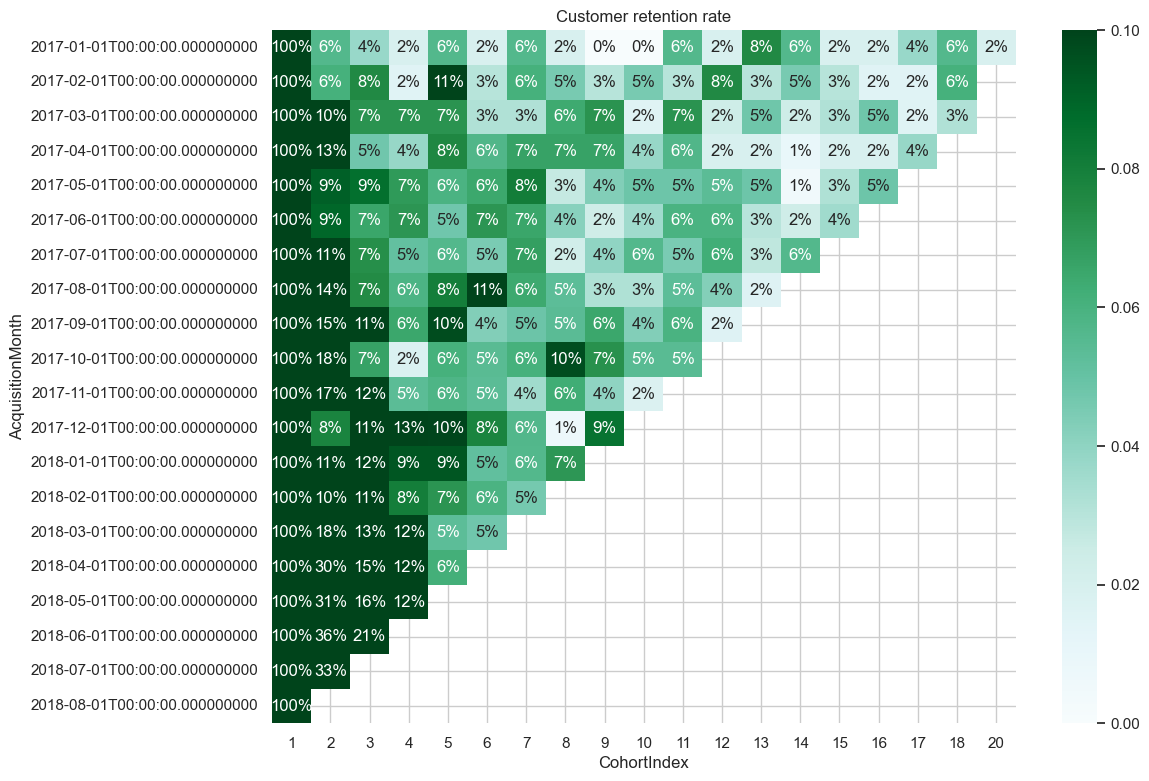

In [ ]:
plt.figure(figsize = (12,9))
plt.title('Customer retention rate')
sns.heatmap(data=retention,
            annot = True,
            fmt = '.0%',
            vmin = 0,
            vmax = 0.10,
            cmap = 'BuGn')
plt.show()

#RFM


In [ ]:
# Dodaje do ostatniej daty zamówienia jeden dzień
last_day = max(df_segmentation_time.order_purchase_timestamp) + dt.timedelta(days = 1 )
# Agreguje dane
datamart = df_segmentation_time.groupby(['customer_unique_id']).agg({
    'order_purchase_timestamp':lambda x: (last_day - x.max()).days,     # Obliczam dni od ostatniego zamówienia do daty zakończenia analizy (Recency)
    'order_id' : 'count',
    'price' : 'sum'
})
datamart.rename(columns = {
                           'order_purchase_timestamp': 'Recency',
                           'order_id': 'Frequency',
                           'price':'MonetaryValue'}, inplace = True)
datamart = datamart.rename_axis('CustomerID')
datamart.head(10)

Recency  Frequency  MonetaryValue
CustomerID                                                         
0000366f3b9a7992bf8c76cfdf3221e2      112          1         129.90
0000b849f77a49e4a4ce2b2a4ca5be3f      115          1          18.90
0000f46a3911fa3c0805444483337064      537          1          69.00
0000f6ccb0745a6a4b88665a16c9f078      321          1          25.99
0004aac84e0df4da2b147fca70cf8255      288          1         180.00
0004bd2a26a76fe21f786e4fbd80607f      146          1         154.00
00050ab1314c0e55a6ca13cf7181fecf      132          1          27.99
00053a61a98854899e70ed204dd4bafe      183          1         191.00
0005e1862207bf6ccc02e4228effd9a0      543          1         135.00
0005ef4cd20d2893f0d9fbd94d3c0d97      170          1         104.90

In [ ]:
datamart['Frequency'].value_counts()

Frequency
1     90955
2      2605
3       184
4        30
5         9
6         3
7         3
9         1
15        1
Name: count, dtype: int64

/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_5505/3008764069.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_5505/3008764069.py:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_5505/3008

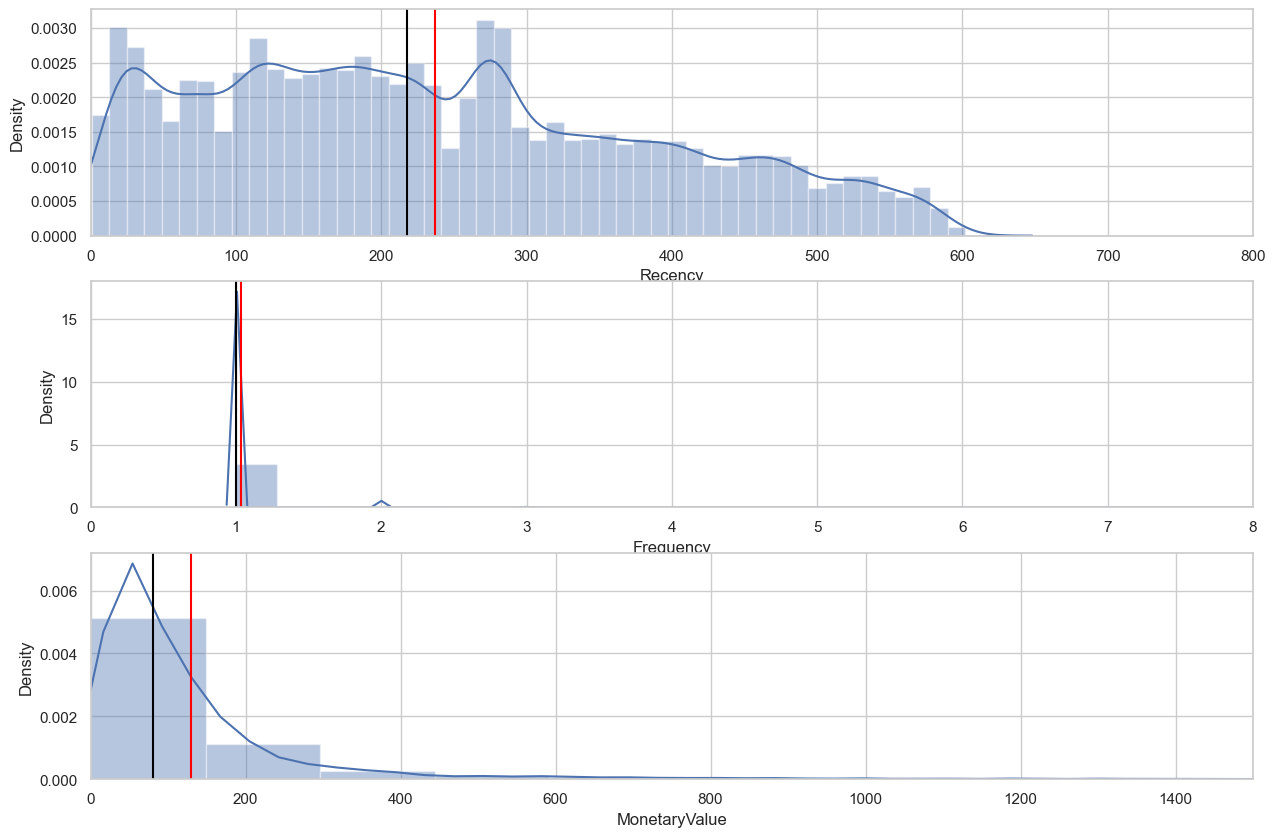

In [ ]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1); sns.distplot(datamart['Recency']),
plt.axvline(datamart['Recency'].mean(), c = 'red')
plt.axvline(datamart['Recency'].median(), c = 'black')
plt.xlim(0, 800)

plt.subplot(3, 1, 2); sns.distplot(datamart['Frequency'])
plt.axvline(datamart['Frequency'].mean(), c = 'red')
plt.axvline(datamart['Frequency'].median(), c = 'black')
plt.xlim(0, 8)

plt.subplot(3, 1, 3); sns.distplot(datamart['MonetaryValue'])
plt.axvline(datamart['MonetaryValue'].mean(), c = 'red')
plt.axvline(datamart['MonetaryValue'].median(), c = 'black')
plt.xlim(0, 1500)

plt.show()

In [ ]:
rfm_datamart = datamart.copy()

r_labels = range(4, 0, -1)
m_labels = range(1,5)

r_quartiles = pd.qcut(rfm_datamart['Recency'], q=4, labels = r_labels)
def adjust_frequency(row):
    if row['Frequency'] == 1:
        return 1
    elif row['Frequency'] == 2:
        return 2
    elif row['Frequency'] == 3:
        return 3
    else:
        return 4
m_quartiles = pd.qcut(rfm_datamart['MonetaryValue'], q=4, labels = m_labels)

rfm_datamart = rfm_datamart.assign(R = r_quartiles.values)
rfm_datamart = rfm_datamart.assign(F = rfm_datamart.apply(adjust_frequency, axis=1))
rfm_datamart = rfm_datamart.assign(M = m_quartiles.values)

rfm_datamart = rfm_datamart[['Recency', 'Frequency', 'MonetaryValue', 'R', 'F', 'M']]

def join_rfm(x):
    return ''.join(map(str, [int(x['R']), int(x['F']), int(x['M'])]))

rfm_datamart['RFM_segment'] = rfm_datamart.apply(join_rfm, axis = 1)
rfm_datamart['RFM_score'] = rfm_datamart[['R', 'F', 'M']].sum(axis = 1)


rfm_datamart.head()

Recency  Frequency  MonetaryValue  R  F  M  \
CustomerID                                                                     
0000366f3b9a7992bf8c76cfdf3221e2      112          1         129.90  4  1  3   
0000b849f77a49e4a4ce2b2a4ca5be3f      115          1          18.90  3  1  1   
0000f46a3911fa3c0805444483337064      537          1          69.00  1  1  2   
0000f6ccb0745a6a4b88665a16c9f078      321          1          25.99  2  1  1   
0004aac84e0df4da2b147fca70cf8255      288          1         180.00  2  1  4   

                                 RFM_segment  RFM_score  
CustomerID                                               
0000366f3b9a7992bf8c76cfdf3221e2         413          8  
0000b849f77a49e4a4ce2b2a4ca5be3f         311          5  
0000f46a3911fa3c0805444483337064         112          4  
0000f6ccb0745a6a4b88665a16c9f078         211          4  
0004aac84e0df4da2b147fca70cf8255         214          7

In [ ]:
rfm_datamart.groupby('RFM_segment').size().sort_values(ascending = False)[:20]

RFM_segment
212    5981
111    5946
411    5913
112    5870
311    5815
412    5791
413    5707
211    5705
313    5661
312    5627
113    5600
213    5583
314    5488
214    5432
114    5429
414    5407
324     395
424     391
224     342
124     287
dtype: int64

In [ ]:
rfm_datamart.groupby('RFM_score').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'MonetaryValue' : ['mean', 'count']}).round(1)


Recency Frequency MonetaryValue       
             mean      mean          mean  count
RFM_score                                       
3           452.9       1.0          26.8   5946
4           361.0       1.0          43.9  11604
5           297.0       1.0          64.7  17494
6           234.1       1.0         129.8  22830
7           169.6       1.0         160.3  17488
8           116.6       1.1         211.7  11861
9            67.1       1.1         323.4   6047
10           70.2       2.1         323.0    438
11           83.6       3.5         421.1     60
12           53.1       5.0         588.8     23

In [ ]:
datamart['Frequency'].value_counts()

Frequency
1     90955
2      2605
3       184
4        30
5         9
6         3
7         3
9         1
15        1
Name: count, dtype: int64

In [ ]:
def segment_client(df):
    if df['RFM_score'] >= 9:
        return 'High segment'
    elif  (6 <= df['RFM_score'] < 9):
        return 'Medium segment'
    else:
        return 'Low segment'

rfm_datamart['General_segment'] = rfm_datamart.apply(segment_client, axis=1)
custom_order = ['High segment', 'Medium segment', 'Low segment']
rfm_datamart['General_segment'] = pd.Categorical(rfm_datamart['General_segment'], categories=custom_order, ordered=True)

result = rfm_datamart.groupby('General_segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

result = result.loc[custom_order]
result

/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_5505/675143264.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Recency Frequency MonetaryValue       
                   mean      mean          mean  count
General_segment                                       
High segment       67.4       1.2         325.2   6568
Medium segment    185.8       1.0         158.6  52179
Low segment       344.6       1.0          51.4  35044

# Data preprocessing to alghoritm Kmeans


In [ ]:
datamart.describe().round(2)

Recency  Frequency  MonetaryValue
count  93791.00   93791.00       93791.00
mean     236.83       1.03         130.20
std      151.25       0.21         196.95
min        1.00       1.00           0.85
25%      114.00       1.00          43.90
50%      218.00       1.00          79.90
75%      345.00       1.00         144.99
max      602.00      15.00        7388.00

In [ ]:
datamart.head()

Recency  Frequency  MonetaryValue
CustomerID                                                         
0000366f3b9a7992bf8c76cfdf3221e2      112          1         129.90
0000b849f77a49e4a4ce2b2a4ca5be3f      115          1          18.90
0000f46a3911fa3c0805444483337064      537          1          69.00
0000f6ccb0745a6a4b88665a16c9f078      321          1          25.99
0004aac84e0df4da2b147fca70cf8255      288          1         180.00

In [ ]:
scaler = StandardScaler()
scaler.fit(datamart)
datamart_normalized = scaler.transform(datamart)
columns_name = ['Recency', 'Frequency', 'MonetaryValue']
X = pd.DataFrame(datamart_normalized, columns = columns_name)
X.describe().round(2)

Recency  Frequency  MonetaryValue
count  93791.00   93791.00       93791.00
mean       0.00       0.00           0.00
std        1.00       1.00           1.00
min       -1.56      -0.16          -0.66
25%       -0.81      -0.16          -0.44
50%       -0.12      -0.16          -0.26
75%        0.72      -0.16           0.08
max        2.41      66.87          36.85

In [ ]:
X.head()

Recency  Frequency  MonetaryValue
0 -0.825331  -0.160997      -0.001536
1 -0.805497  -0.160997      -0.565129
2  1.984536  -0.160997      -0.310750
3  0.556462  -0.160997      -0.529130
4  0.338284  -0.160997       0.252842

# Kmeans


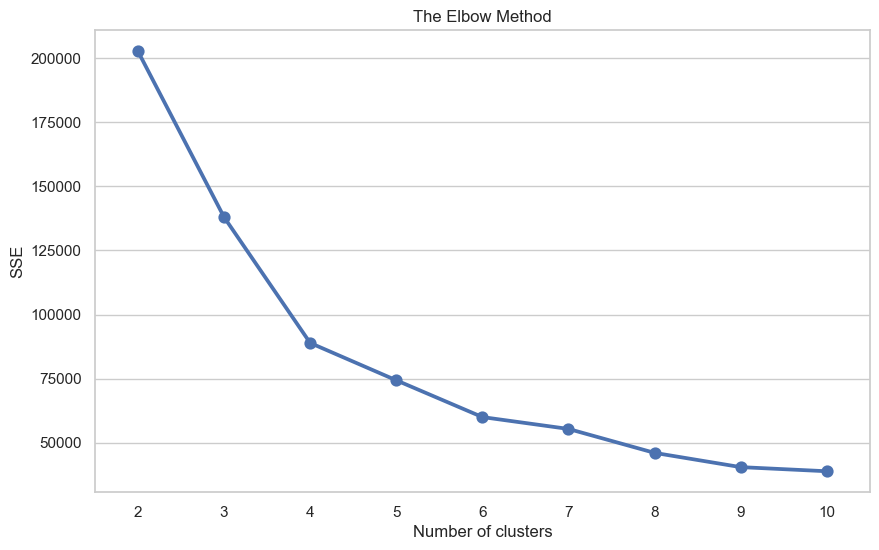

In [ ]:
#Elbow Curve

sse = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9 ,10]

for num_clusters in range_n_clusters:
    kmeans =KMeans(n_clusters=num_clusters, max_iter= 50, random_state= 42)
    kmeans.fit(X)

    sse.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
sns.pointplot(x=range_n_clusters, y=sse, markers='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [ ]:
#Silhouette Analysis
silhouette_scores = []

for num_clusters in range_n_clusters:
    kmeans =KMeans(n_clusters=num_clusters, max_iter= 50, random_state= 42)
    kmeans.fit(X)
    cluster_labels = kmeans.labels_
    #silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print('For n_clusters = {0}, the silhouette score is {1}'. format(num_clusters, silhouette_avg))

For n_clusters = 2, the silhouette score is 0.7365515713800581
For n_clusters = 3, the silhouette score is 0.46097481143596225
For n_clusters = 4, the silhouette score is 0.49548430996860865
For n_clusters = 5, the silhouette score is 0.4257093219405185
For n_clusters = 6, the silhouette score is 0.4436798871108878
For n_clusters = 7, the silhouette score is 0.38108226423587077
For n_clusters = 8, the silhouette score is 0.3835413263975446
For n_clusters = 9, the silhouette score is 0.3955761609051574
For n_clusters = 10, the silhouette score is 0.3878090313678186


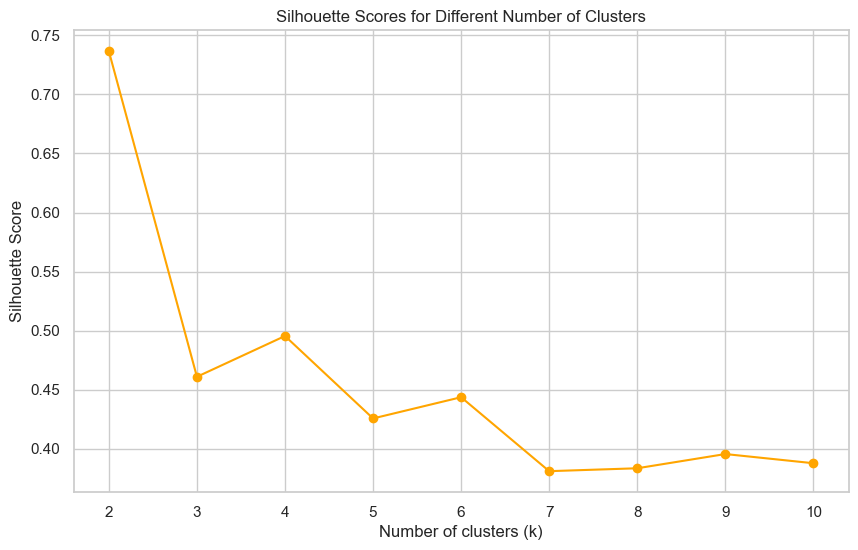

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [ ]:
X.head()

Recency  Frequency  MonetaryValue
0 -0.825331  -0.160997      -0.001536
1 -0.805497  -0.160997      -0.565129
2  1.984536  -0.160997      -0.310750
3  0.556462  -0.160997      -0.529130
4  0.338284  -0.160997       0.252842

In [ ]:
kmeans = KMeans(n_clusters= 4, max_iter= 50, random_state= 42)
kmeans.fit(X)

KMeans(max_iter=50, n_clusters=4, random_state=42)

In [ ]:
X['customerID'] = datamart.index

X['Cluster'] = kmeans.labels_
X.head(10)

Recency  Frequency  MonetaryValue                        customerID  \
0 -0.825331  -0.160997      -0.001536  0000366f3b9a7992bf8c76cfdf3221e2   
1 -0.805497  -0.160997      -0.565129  0000b849f77a49e4a4ce2b2a4ca5be3f   
2  1.984536  -0.160997      -0.310750  0000f46a3911fa3c0805444483337064   
3  0.556462  -0.160997      -0.529130  0000f6ccb0745a6a4b88665a16c9f078   
4  0.338284  -0.160997       0.252842  0004aac84e0df4da2b147fca70cf8255   
5 -0.600542  -0.160997       0.120829  0004bd2a26a76fe21f786e4fbd80607f   
6 -0.693102  -0.160997      -0.518975  00050ab1314c0e55a6ca13cf7181fecf   
7 -0.355918  -0.160997       0.308694  00053a61a98854899e70ed204dd4bafe   
8  2.024205  -0.160997       0.024359  0005e1862207bf6ccc02e4228effd9a0   
9 -0.441867  -0.160997      -0.128471  0005ef4cd20d2893f0d9fbd94d3c0d97   

   Cluster  
0        0  
1        0  
2        2  
3        2  
4        2  
5        0  
6        0  
7        0  
8        2  
9        0

<Axes: xlabel='Cluster', ylabel='MonetaryValue'>

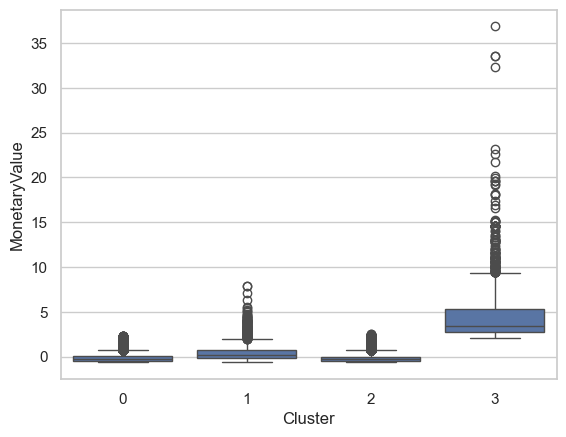

In [ ]:
sns.boxplot(x='Cluster', y='MonetaryValue', data = X)

<Axes: xlabel='Cluster', ylabel='Frequency'>

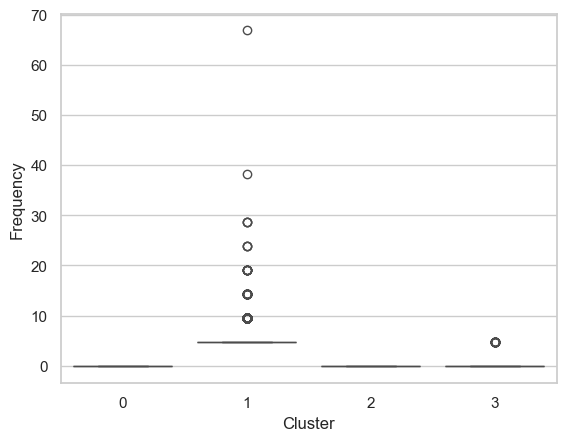

In [ ]:
sns.boxplot(x='Cluster', y='Frequency', data = X)

<Axes: xlabel='Cluster', ylabel='Recency'>

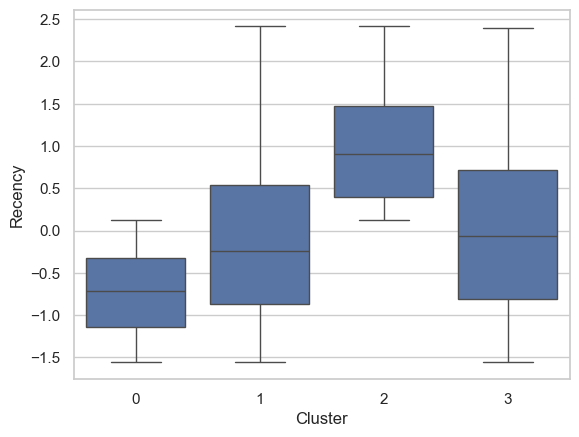

In [ ]:
sns.boxplot(x='Cluster', y='Recency', data = X)

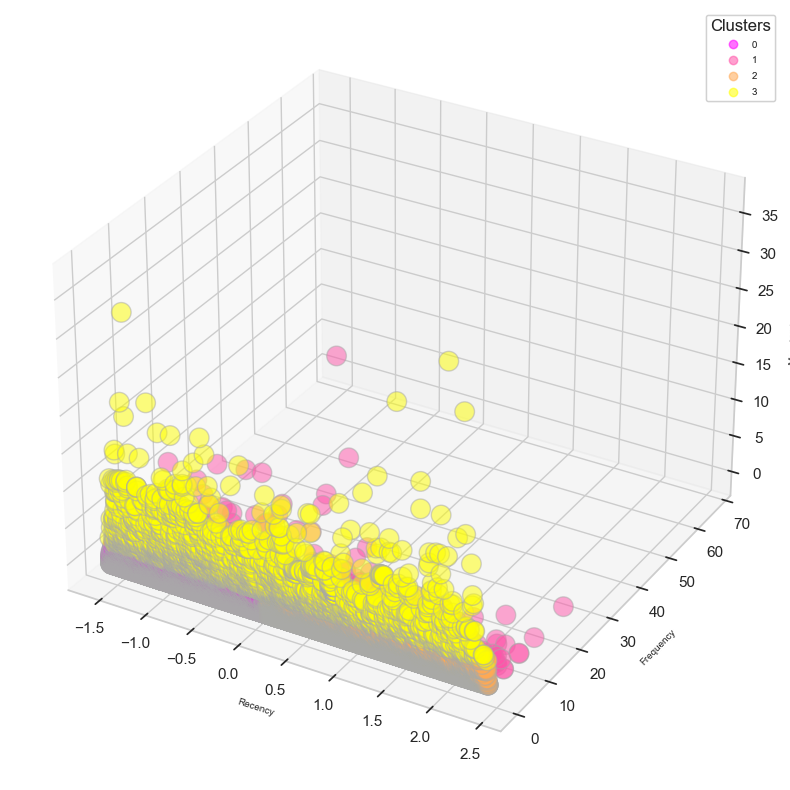

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X['Recency'], X['Frequency'], X['MonetaryValue'],
           c = X['Cluster'],
           s = 200,
           cmap = 'spring',
           alpha = 0.5,
           edgecolor = 'darkgray')

ax.set_xlabel('Recency', fontsize = 7)
ax.set_ylabel('Frequency', fontsize = 7)
ax.set_zlabel('MonetaryValue', fontsize = 7)

legend = ax.legend(*sc.legend_elements(), title="Clusters", loc="upper right", fontsize=7)
ax.add_artist(legend)


plt.show()

In [ ]:
pip install --upgrade nbformat

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 78 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 322 kB 4.2 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pio.renderers.default = 'notebook'

fig = px.scatter_3d(X, x='Recency', y='Frequency', z='MonetaryValue', color='Cluster',
                    title='3D Scatter Plot of Customer Segments')

# Wyświetlenie wykresu
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

AttributeError: type object 'Axes3D' has no attribute 'X'

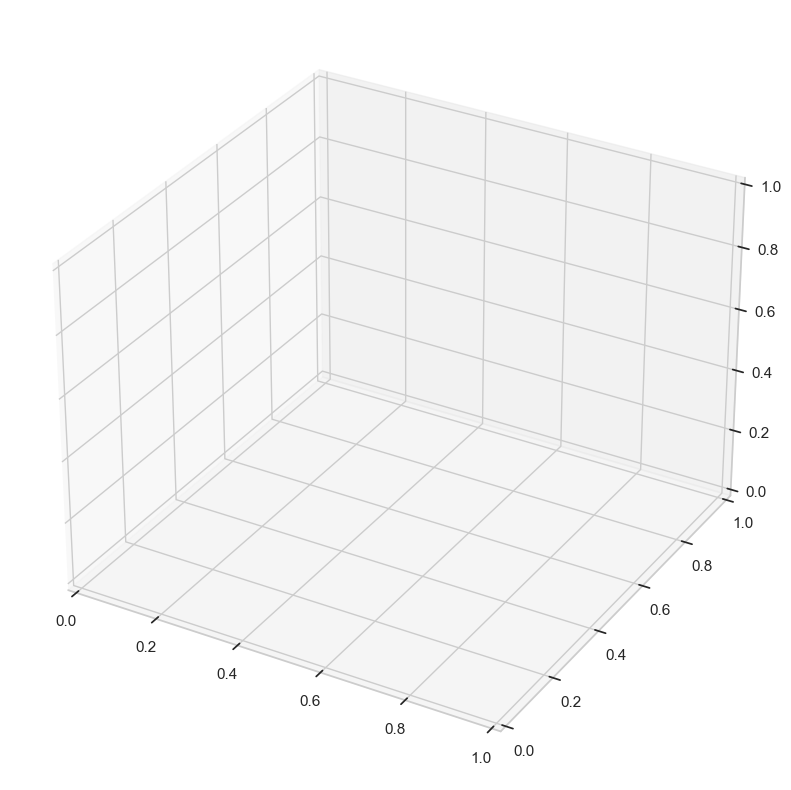

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Grab some example data and plot a basic wireframe.
X['Recency'], X['Frequency'], X['MonetaryValue'] = Axes3D.X
ax.plot_wireframe(X['Recency'], X['Frequency'], X['MonetaryValue'], rstride=10, cstride=10)

# Set the axis labels
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('MonetaryValue')

# Rotate the axes and update
for angle in range(0, 360*4 + 1):
    # Normalize the angle to the range [-180, 180] for display
    angle_norm = (angle + 180) % 360 - 180

    # Cycle through a full rotation of elevation, then azimuth, roll, and all
    elev = azim = roll = 0
    if angle <= 360:
        elev = angle_norm
    elif angle <= 360*2:
        azim = angle_norm
    elif angle <= 360*3:
        roll = angle_norm
    else:
        elev = azim = roll = angle_norm

    # Update the axis view and title
    ax.view_init(elev, azim, roll)
    plt.title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))

    plt.draw()
    plt.pause(.001)

In [ ]:

# Konwersja danych do siatki (meshgrid)
Recency, Frequency = np.meshgrid(X['Recency'], X['Frequency'])
MonetaryValue = np.meshgrid(X['MonetaryValue'], X['MonetaryValue'])[0]  # Stworzenie odpowiedniej siatki dla wartości Z

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Tworzenie wykresu wireframe
ax.plot_wireframe(Recency, Frequency, MonetaryValue, rstride=1, cstride=1)

# Etykiety osi
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('MonetaryValue')

# Obracanie wykresu
for angle in range(0, 360*4 + 1):
    # Normalizacja kąta do zakresu [-180, 180] dla wyświetlania
    angle_norm = (angle + 180) % 360 - 180

    # Rotacja przez pełny obrót nachylenia, azymutu, roll, i wszystkich
    elev = azim = roll = 0
    if angle <= 360:
        elev = angle_norm
    elif angle <= 360*2:
        azim = angle_norm
    elif angle <= 360*3:
        roll = angle_norm
    else:
        elev = azim = roll = angle_norm

    # Aktualizacja widoku osi i tytułu
    ax.view_init(elev, azim)
    plt.title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))

    plt.draw()
    plt.pause(.001)

plt.show()

NameError: name 'X' is not defined

In [ ]:
start_time = time.time()
end_time = time.time()
def calculate_loading_time(start_time, end_time):
    duration = end_time - start_time
    if duration < 60:
        # Czas ładowania jest mniejszy niż 60 sekund
        loading_time = f"{duration:.3f} sekundy"
    else:
        # Czas ładowania jest większy niż 60 sekund, konwertuj na minuty i sekundy
        minutes = int(duration // 60)
        seconds = duration % 60
        loading_time = f"{minutes} minut {seconds:.3f} sekundy"

    return loading_time



In [ ]:
start_time
# Inicjalizacja pustego słownika dla sumy kwadratów błędów (SSE)
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)  # Inicjalizacja KMeans dla aktualnego k
    kmeans.fit(datamart)  # Dopasowanie KMeans do znormalizowanych danych
    sse[k] = kmeans.inertia_  # Przypisanie SSE dla aktualnego k
end_time
loading_time = (end_time - start_time)

# Pobram etykiety klastrów z ostatniej iteracji KMeans
cluster_labels = kmeans.labels_
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()
print(f"Czas ładowania algorytmu: {loading_time}")

In [ ]:
n_clusters = [ 3, 4, 5, 6, 7, 8, 9 , 10]
silhouette_scores = []
start_time = time.time()
for K in n_clusters:
    initialized_clusters = KMeans(n_clusters = K, random_state = 10)
    data_fitted_clusters = initialized_clusters.fit_predict(datamart)

    silhouette_avg = silhouette_score(datamart, data_fitted_clusters)
    print(
        "For n_clusters =",
        K,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    sample_silhouette_values = silhouette_samples(datamart, data_fitted_clusters)

    #silhoette_score = silhouette_score(datamart, data_fitted_clusters, random_state = 42)
    #silhouette_scores.append(silhoette_score)

#plt.plot(n_clusters, silhouette_scores, color = 'b', marker = '*')
#plt.title('Cluster Scores', fontsize = 15)
#plt.xlabel('Number of Clusters', fontsize = 12)
#plt.ylabel('Silhouette Score', fontsize = 12)
#plt.show()

In [ ]:
y_lower = 10
for i in range(K):
    ith_cluster_silhouette_values = sample_silhouette_values[data_fitted_clusters == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper +


ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")



In [ ]:
start_time
sse = {}
for k in range(1,11):
  kmeans = KMeans(n_clusters=k, random_state = 10)
  kmeans.fit(datamart)
  sse[k] = kmeans.inertia_
  plt.title('The Elbow Method')
end_time
loading_time = (end_time - start_time)

plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()
print(f"Czas ładowania algorytmu: {loading_time} sekundy")

# Cluster analysis


In [ ]:
datamart_k2 = datamart.assign(Cluster = cluster_labels)
datamart_k2.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

In [ ]:
silhouette_score(datamart, cluster_labels).round(3)

In [ ]:
datamart.head()

In [ ]:
kmeans = KMeans(n_clusters=4, init = 'k-means++', random_state = 1)
kmeans.fit(datamart)
df_segm4_Kmeans = datamart.copy()
df_segm4_Kmeans['segment'] = kmeans.labels_
df_segm4_Kmeans.head()
df_segment4_grouped = df_segm4_Kmeans.groupby(['segment']).agg({
      'Recency': 'mean',
      'Frequency': 'mean',
      'MonetaryValue': ['mean', 'count']
}).round(1)

df_segment4_grouped

In [ ]:
kmeans = KMeans(n_clusters=5, init = 'k-means++', random_state = 1)
kmeans.fit(datamart)
df_segm5_Kmeans = datamart.copy()
df_segm5_Kmeans['segment'] = kmeans.labels_
df_segm5_Kmeans.head()
df_segment5_grouped = df_segm5_Kmeans.groupby(['segment']).agg({
      'Recency': 'mean',
      'Frequency': 'mean',
      'MonetaryValue': ['mean', 'count']
}).round(1)

df_segment5_grouped

In [ ]:
df_segm4_Kmeans['segment'].value_counts()

In [ ]:
df_segm4_Kmeans[df_segm4_Kmeans['segment'] == 1 ].head()

In [ ]:
df_analysis = df_segm4_Kmeans.groupby('segment').mean().round(2)

df_analysis['#observations'] = df_segm4_Kmeans[['segment','Frequency']].groupby(['segment']).count()
df_analysis['Percentage'] = df_analysis['#observations'] / df_analysis['#observations'].sum()
df_analysis['Percentage'].round(3)
df_analysis.round(3)

In [ ]:
x_axis = df_segm5_Kmeans['MonetaryValue']
y_axis = df_segm5_Kmeans['Recency']
plt.figure(figsize = (10,6))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_segm5_Kmeans['segment'],
                palette = 'Set2', legend = 'full')
plt.show()

In [ ]:
y_axis = df_segm5_Kmeans['Frequency']
x_axis = df_segm5_Kmeans['Recency']
plt.figure(figsize = (10,6))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_segm5_Kmeans['segment'],
                palette = 'Set2', legend = 'full')
plt.show()

In [ ]:
x_axis = df_segm5_Kmeans['MonetaryValue']
y_axis = df_segm5_Kmeans['Frequency']
plt.figure(figsize = (10,6))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_segm5_Kmeans['segment'],
                palette = 'Set2', legend = 'full')
plt.show()

In [ ]:
# Inicjalizacja figury i osi 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for segment in range(5):  # 5 klastrów
    segment_data = df_segm5_Kmeans[df_segm5_Kmeans['segment'] == segment]
    ax.scatter(segment_data['Recency'], segment_data['Frequency'], segment_data['MonetaryValue'], label=f'Segment {segment}')

# Ustawienie tytułów dla osi
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('MonetaryValue')

# Dodanie legendy
ax.legend()

# Wyświetlenie wykresu
plt.title('Wykres 3D dla segmentów KMeans')
plt.show()

In [ ]:
pca = PCA(n_components = 3)

pca.fit(datamart_normalized)

PC1_label = "PC1 {}%".format(round((100*pca.explained_variance_ratio[0]),2))
PC2_label = "PC2 {}%".format(round((100*pca.explained_variance_ratio[1]),2))
PC3_label = "PC3 {}%".format(round((100*pca.explained_variance_ratio[2]),2))

In [ ]:
figPCA = px.scatter_3d(segment_data, x = df_segm5_Kmeans['Recency'], y =  df_segm5_Kmeans['Frequency'], z = df_segm5_Kmeans['MonetaryValue'],
                       title = "Wykres 3D dla segmentów KMeans",
                       template = 'plotly_white', height = 800, width = 800)

figPCA.show()

In [ ]:
segment_data[segment_data['segment'] != 4].head()
df_segm5_Kmeans.head()

# More data to alghoritm



In [ ]:
df_olist.head(10)

In [ ]:
df = df_olist[['order_id', 'customer_id','customer_unique_id', 'order_purchase_timestamp', 'product_category_name', 'product_category_name_english', 'payment_installments', 'payment_type','price', 'review_score', 'review_comment_message', 'review_comment_title', 'customer_zip_code_prefix', 'customer_city', 'customer_state' ]]
df.head()

In [ ]:
df.isnull().sum()

Usuwam wartosci: payment_installments, payment_type ,review_score.

Wartości: review_comment_message, review_comment_title zamienam na układ binarny gdzie 1-zostawil wiadomosc/tytul, 0-nie zostawil


In [ ]:
df = df.dropna(subset = ['payment_installments', 'payment_type','review_score'])
df.isnull().sum()

In [ ]:
def text_handler(value):
  if pd.isnull(value):
    return 0
  else:
    return 1

df['review_comment_message'] = df['review_comment_message'].apply(lambda x: text_handler(x))
df['review_comment_title'] = df['review_comment_title'].apply(lambda x: text_handler(x))

df.isnull().sum()

In [ ]:
df['product_category_name_english'].value_counts()[:10]

In [ ]:
df.head()

In [ ]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df = df[(df['order_purchase_timestamp'] >= '2017-01-01') & (df['order_purchase_timestamp'] <= '2018-08-31')]

In [ ]:
last_date = max(df.order_purchase_timestamp) + dt.timedelta(days = 1 )
first_date = min(df.order_purchase_timestamp)
print(f'First date: {first_date} AND last date: {last_date}')

In [ ]:
df_extended = df.groupby(['customer_unique_id']).agg({
    'order_purchase_timestamp':lambda x: (last_date - x.max()).days,
    'order_id' : 'count',
    'price' : 'sum'})

df_extended.rename(columns = {
                           'order_purchase_timestamp': 'Recency',
                           'order_id': 'Frequency',
                           'price':'MonetaryValue'},
                            inplace = True)
df_extended.reset_index(inplace=True)

additional_columns = df[['customer_unique_id', 'product_category_name_english', 'payment_installments', 'payment_type', 'review_score', 'review_comment_message', 'review_comment_title', 'customer_zip_code_prefix', 'customer_city', 'customer_state']]
df_extended = df_extended.merge(additional_columns, on='customer_unique_id', how='left')
df_extended.set_index('customer_unique_id', inplace=True)
df_extended = df_extended.rename_axis('CustomerID')
df_extended.rename(columns = {
                              'product_category_name_english': 'ProductCategoryName',
                              'payment_installments':'Installments',
                              'payment_type' : 'PaymentType',
                              'review_score': 'ReviewScore',
                              'review_comment_message': 'ReviewMessage',
                              'review_comment_title' : 'ReviewTitle',
                              'customer_zip_code_prefix' : 'Zip-code',
                              'customer_city': 'City',
                              'customer_state': 'State'}, inplace = True)




In [ ]:
df_extended.head()

In [ ]:
df.head()

In [ ]:
df_satisfaction = df_extended.drop(columns={'ProductCategoryName', 'Installments','PaymentType','Zip-code','City', 'State'})
df_satisfaction.head(20)
df_satisfaction.describe().round(2)

In [ ]:
plt.figure(figsize=(20, 15))
sns.displot(df_satisfaction['Recency'], kde=True)
sns.displot(df_satisfaction['Frequency'], kde=True)
sns.displot(df_satisfaction['MonetaryValue'],kde=True)
sns.displot(df_satisfaction['ReviewScore'],kde=True)
sns.displot(df_satisfaction['ReviewTitle'],kde=True)
sns.displot(df_satisfaction['ReviewMessage'],kde=True)

plt.show()

In [ ]:
df_satisfaction.head()

In [ ]:
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

data_to_scaler = df_satisfaction[['Recency', 'Frequency', 'MonetaryValue']]
data_to_min_max = df_satisfaction['ReviewScore']

standardized_data = standard_scaler.fit_transform(data_to_scaler)
min_max_scaled = min_max_scaler.fit_transform(data_to_min_max.values.reshape(-1, 1))

#df_satisfaction_standrized = pd.DataFrame()
#df_satisfaction_standrized['Recency'], df_satisfaction_standrized['Frequency'], df_satisfaction_standrized['MonetaryValue'], df_satisfaction_standrized['ReviewScore'] ,  df_satisfaction_standrized['ReviewTitle'],  df_satisfaction_standrized['ReviewMessage'] = \
#    standardized_data[:, 0], standardized_data[:, 1], standardized_data[:, 2], min_max_scaled, df_satisfaction['ReviewTitle'], df_satisfaction['ReviewMessage']

df_satisfaction_standrized = pd.DataFrame({
    'Recency': standardized_data[:, 0],
    'Frequency': standardized_data[:, 1],
    'MonetaryValue': standardized_data[:, 2],
    'ReviewScore': min_max_scaled.flatten(),  # Spłaszczenie tablicy do jednego wymiaru
    'ReviewTitle': df_satisfaction['ReviewTitle'],
    'ReviewMessage': df_satisfaction['ReviewMessage']
    })

#df_satisfaction_standrized['ReviewTitle'] = df_satisfaction['ReviewTitle']
#df_satisfaction_standrized['ReviewMessage'] = df_satisfaction['ReviewMessage']

df_satisfaction_standrized.describe().round(2)

In [ ]:
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

data_to_scaler = df_satisfaction[['Recency', 'Frequency', 'MonetaryValue']]
data_to_min_max = df_satisfaction['ReviewScore']

standardized_data = standard_scaler.fit_transform(data_to_scaler)
min_max_scaled = min_max_scaler.fit_transform(data_to_min_max.values.reshape(-1, 1))

df_satisfaction_standrized = pd.DataFrame()
df_satisfaction_standrized[['Recency', 'Frequency', 'MonetaryValue']] = standardized_data[:, :3]
df_satisfaction_standrized['ReviewScore'] = min_max_scaled
#df_satisfaction_standrized[['ReviewTitle', 'ReviewMessage']] = df_satisfaction[['ReviewTitle', 'ReviewMessage']]

df_satisfaction_standrized.describe().round(2)


In [ ]:
n_clusters = [ 3, 4, 5, 6, 7, 8, 9 , 10]
silhouette_scores = []
for K in n_clusters:
    initialized_clusters = KMeans(n_clusters = K, random_state = 42)
    data_fitted_clusters = initialized_clusters.fit_predict(df_satisfaction_standrized)
    silhoette_score = silhouette_score(df_satisfaction_standrized, data_fitted_clusters, random_state = 10)
    silhouette_scores.append(silhoette_score)


plt.plot(n_clusters, silhouette_scores, color = 'b', marker = '*')
plt.title('Cluster Scores', fontsize = 15)
plt.xlabel('Number of Clusters', fontsize = 12)
plt.ylabel('Silhouette Score', fontsize = 12)
plt.show()

In [ ]:
sse = {}
for k in range(1,11):
  kmeans = KMeans(n_clusters=k, random_state = 1)
  kmeans.fit(df_satisfaction_standrized)
  sse[k] = kmeans.inertia_
  plt.title('The Elbow Method')


plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=4, init = 'k-means++', random_state = 42)
kmeans.fit(df_satisfaction_standrized)
clusters_4 = df_satisfaction_standrized.copy()
clusters_4['segment'] = kmeans.labels_
clusters_4.head()
df_clusters_4 = clusters_4.groupby(['segment']).agg({
      'Recency': 'mean',
      'Frequency': 'mean',
      'MonetaryValue' : 'mean',
      'ReviewScore' : ['mean', 'count'] }).round(1)

df_clusters_4

In [ ]:
kmeans = KMeans(n_clusters=5, init = 'k-means++', random_state = 42)
kmeans.fit(df_satisfaction_standrized)
clusters_5 = df_satisfaction_standrized.copy()
clusters_5['segment'] = kmeans.labels_
clusters_5.head()
df_clusters_5 = clusters_5.groupby(['segment']).agg({
      'Recency': 'mean',
      'Frequency': 'mean',
      'MonetaryValue' : 'mean',
      'ReviewScore' : ['mean', 'count'] }).round(1)

df_clusters_5

In [ ]:
x_axis = clusters_5['MonetaryValue']
y_axis = clusters_5['Recency']
plt.figure(figsize = (10,6))
sns.scatterplot(x = x_axis, y = y_axis, hue = 'segment', data = clusters_5,
                palette = 'Set2', legend = 'full')
plt.show()

In [ ]:
x_axis = clusters_4['MonetaryValue']
y_axis = clusters_4['Recency']
plt.figure(figsize = (10,6))
sns.scatterplot(x = x_axis, y = y_axis, hue = 'segment', data = clusters_4,
                palette = 'Set2', legend = 'full')
plt.show()

In [ ]:
datamart.describe()

In [ ]:
df_satisfaction_standrized.describe().round(3)

In [ ]:
from sklearn.cluster import DBSCAN
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1

for x in range(10, 0, -1):
    eps = 1 / (11 - x)
    db = DBSCAN(eps=eps, min_samples=10).fit(datamart_normalized)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    ax = fig.add_subplot(2, 5, i)
    ax.text(0.5, 1.05, "eps = {}".format(round(eps, 2)), fontsize=15, ha="center", transform=ax.transAxes)

    # Rysowanie klastrów
    sns.scatterplot(x=datamart_normalized[:, 0], y=datamart_normalized[:, 1], hue=["cluster-{}".format(label) for label in labels], ax=ax, palette='viridis', legend=None)
    ax.set_title(f"DBSCAN with eps = {round(eps, 2)}")

    i += 1

plt.show()